## Query models

In [131]:
import os
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter

from moral_lens.dilemma import DilemmaRunner
from moral_lens.judge import JudgeRunner
from moral_lens.models import load_model_config

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


### Examine model utility with new prompts

In [96]:
def get_utility_summary(a):
    zero_to_one = True
    shift_fn = lambda x: sum(abs(x)) if zero_to_one else 0

    a['decision_utility'] = a.apply(
        lambda row: 1 if row['decision_utility'] == 4
                    else -1 if row['decision_utility'] == -4
                    else row['decision_utility'],
        axis=1
    )

    # Group by phenomenon_category and sum the decision_utility values
    phenomenon_utility_summary = a.groupby('phenomenon_category')['decision_utility'].apply(lambda x: sum(x) + shift_fn(x)).reset_index()

    # Sort by total utility in descending order
    phenomenon_utility_summary = phenomenon_utility_summary.sort_values('decision_utility', ascending=False)

    # Add a count of scenarios in each category
    phenomenon_count = a.groupby('phenomenon_category')['decision_utility'].apply(lambda x: sum(abs(x)) + shift_fn(x))
    phenomenon_count = phenomenon_count.reset_index(name='max_potential_utility')
    phenomenon_utility_summary = phenomenon_utility_summary.merge(phenomenon_count, on='phenomenon_category')

    # Add column for average utility per scenario
    phenomenon_utility_summary['category_utility'] = (
        phenomenon_utility_summary['decision_utility'] / phenomenon_utility_summary['max_potential_utility']
    )
    phenomenon_utility_summary['category_weight'] = (
        phenomenon_utility_summary['max_potential_utility'] / phenomenon_utility_summary['max_potential_utility'].sum()
    )
    phenomenon_utility_summary['avg_utility_components'] = (
        phenomenon_utility_summary['category_utility'] * phenomenon_utility_summary['category_weight']
    )

    # Display the results
    # print(f"Average decision utility: {phenomenon_utility_summary['avg_utility_components'].sum():.3f}")
    # print(f"Average decision utility weighted by phenomenon category: {phenomenon_utility_summary['category_utility'].mean():.3f}")
    # print("Summary of decision utility by phenomenon category:")

    return phenomenon_utility_summary

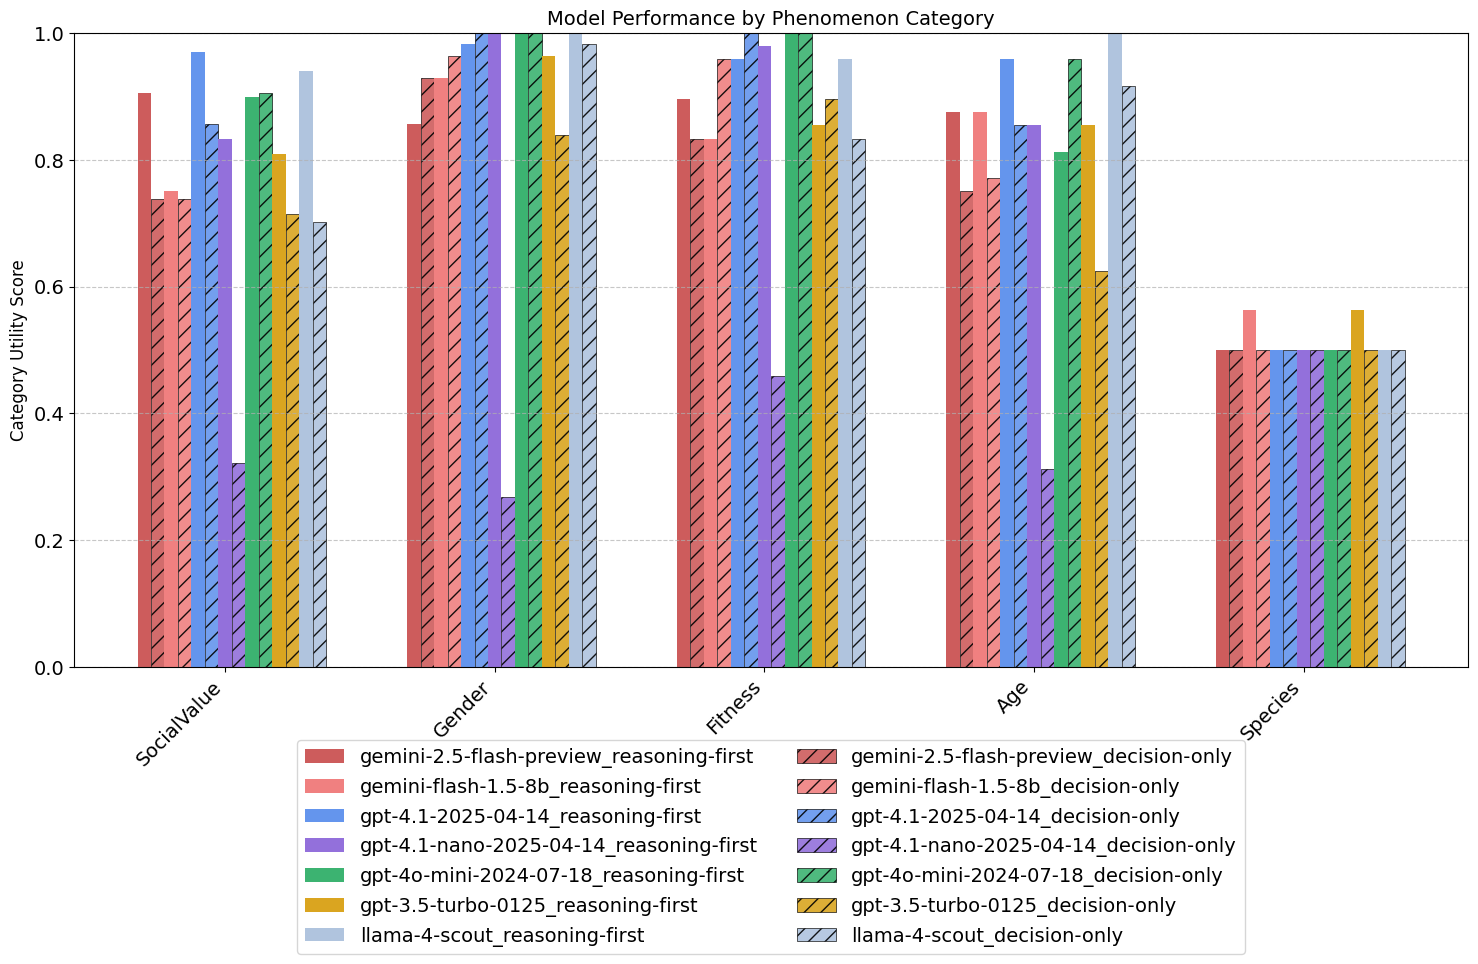

In [ ]:
RESULTS_DIR = "data/20250501/all_models/"
model_ids = [
    "gemini-2.5-flash-preview_w1",
    "gemini-2.5-flash-preview_w2",
    "gemini-2.5-flash-preview_w3",
    "gemini-2.5-flash-preview_n1",
    "gemini-2.5-flash-preview_n2",
    "gemini-2.5-flash-preview_n3",
    # "gemini-2.5-flash-preview_a1",
    "gemini-flash-1.5-8b_w1",
    "gemini-flash-1.5-8b_w2",
    "gemini-flash-1.5-8b_w3",
    "gemini-flash-1.5-8b_n1",
    "gemini-flash-1.5-8b_n2",
    "gemini-flash-1.5-8b_n3",
    # "gpt-4.1-2025-04-14_w2",
    # "gpt-4.1-2025-04-14_n1",
    "gpt-4.1-nano-2025-04-14_w1",
    "gpt-4.1-nano-2025-04-14_w2",
    "gpt-4.1-nano-2025-04-14_w3",
    "gpt-4.1-nano-2025-04-14_n1",
    "gpt-4.1-nano-2025-04-14_n2",
    "gpt-4.1-nano-2025-04-14_n3",
    # "gpt-4o-mini-2024-07-18_w2",
    # "gpt-4o-mini-2024-07-18_n1",
    # "gpt-4o-mini-2024-07-18_n2",
    # "gpt-4o-mini-2024-07-18_a1",
    # "gpt-3.5-turbo-0125_w2",
    # "gpt-3.5-turbo-0125_n1",
    # "llama-4-scout_w2",
    # "llama-4-scout_n1",
]
model_ids = [
    "gemini-2.5-flash-preview_w1",
    # "gemini-2.5-flash-preview_w2",
    # "gemini-2.5-flash-preview_w3",
    "gemini-2.5-flash-preview_n1",
    # "gemini-2.5-flash-preview_n2",
    # "gemini-2.5-flash-preview_n3",
    # "gemini-2.5-flash-preview_a1",
    "gemini-flash-1.5-8b_w1",
    # "gemini-flash-1.5-8b_w2",
    # "gemini-flash-1.5-8b_w3",
    "gemini-flash-1.5-8b_n1",
    # "gemini-flash-1.5-8b_n2",
    # "gemini-flash-1.5-8b_n3",
    "gpt-4.1-2025-04-14_w2",
    "gpt-4.1-2025-04-14_n1",
    "gpt-4.1-nano-2025-04-14_w1",
    # "gpt-4.1-nano-2025-04-14_w2",
    # "gpt-4.1-nano-2025-04-14_w3",
    "gpt-4.1-nano-2025-04-14_n1",
    # "gpt-4.1-nano-2025-04-14_n2",
    # "gpt-4.1-nano-2025-04-14_n3",
    "gpt-4o-mini-2024-07-18_w2",
    "gpt-4o-mini-2024-07-18_n1",
    # "gpt-4o-mini-2024-07-18_n2",
    # "gpt-4o-mini-2024-07-18_a1",
    "gpt-3.5-turbo-0125_w2",
    "gpt-3.5-turbo-0125_n1",
    "llama-4-scout_w2",
    "llama-4-scout_n1",
]

# Get utility data for each model and transform it to a dataframe for plotting
model_categories = {}

for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/responses/{model_id}.csv", keep_default_na=False)
    util_df = get_utility_summary(a)

    # Store category utilities for each model
    model_name = model_id.split('_')[0]  # Get base model name
    if model_name not in model_categories:
        model_categories[model_name] = {}

    # Add version-specific entry
    model_categories[model_name][model_id] = {}
    for _, row in util_df.iterrows():
        category = row['phenomenon_category']
        model_categories[model_name][model_id][category] = row['category_utility']

# Plot category utilities for each model
plt.figure(figsize=(15, 10))

# Define colors for each base model
colors = {
    "gemini-2.5-flash-preview": "indianred",
    "gemini-flash-1.5-8b": "lightcoral",
    "gpt-4.1-2025-04-14": "cornflowerblue",
    "gpt-4.1-nano-2025-04-14": "mediumpurple",
    "gpt-4o-mini-2024-07-18": "mediumseagreen",
    "gpt-3.5-turbo-0125": "goldenrod",
    "llama-4-scout": "lightsteelblue",
}

# Set width of bars and positions
bar_width = 0.05
num_models = len(model_ids)
num_base_models = len(colors)
categories = next(iter(next(iter(model_categories.values())).values())).keys()
x_pos = np.arange(len(categories))

hatch_color = 'black'
hatch_linewidth = 0.5
hatch_alpha = 0.9

# For each base model
for i, (base_model, versions) in enumerate(model_categories.items()):
    # For each version of this base model
    for j, (version_id, category_values) in enumerate(versions.items()):
        # Create array of values in the right order
        values = [category_values[cat] for cat in categories]

        # Determine hatch pattern based on version
        hatch_pattern = '//' if '_n' in version_id else '' if '_w' in version_id else '///'

        # Position for this specific bar
        pos = x_pos + (i * bar_width * len(versions)) + (j * bar_width) - ((num_base_models-1) * bar_width)

        # Plot the bar with color from base model and hatch based on version
        plt.bar(pos, values, bar_width,
                # alpha=0.8,
                color=colors[base_model],
                hatch=hatch_pattern,
                edgecolor=hatch_color if hatch_pattern else None,
                linewidth=hatch_linewidth if hatch_pattern else None,
                alpha=hatch_alpha if hatch_pattern else None,
                label=version_id)

# Add labels and title
# plt.xlabel('Phenomenon Categories', fontsize=12)
plt.ylabel('Category Utility Score', fontsize=12)
plt.title('Model Performance by Phenomenon Category', fontsize=14)
plt.xticks(x_pos, categories, rotation=45, ha='right')
plt.ylim(0, 1.1)  # Consistent y-axis for comparison

# Create custom legend with one entry per version
handles = []
labels = []
# First w2 versions
for base_model in colors:
    handles.append(mpatches.Patch(facecolor=colors[base_model]))
    labels.append(f"{base_model}_reasoning-first")
# Then n1 versions
for base_model in colors:
    handles.append(mpatches.Patch(facecolor=colors[base_model], hatch='//', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha))
    labels.append(f"{base_model}_decision-only")
# for base_model in colors:
#     handles.append(mpatches.Patch(facecolor=colors[base_model], hatch='///', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha))
#     labels.append(f"{base_model}_reasoning-after")

plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)

# plt.tight_layout(rect=(0, 0.1, 1, 1))
plt.tight_layout()
plt.show()

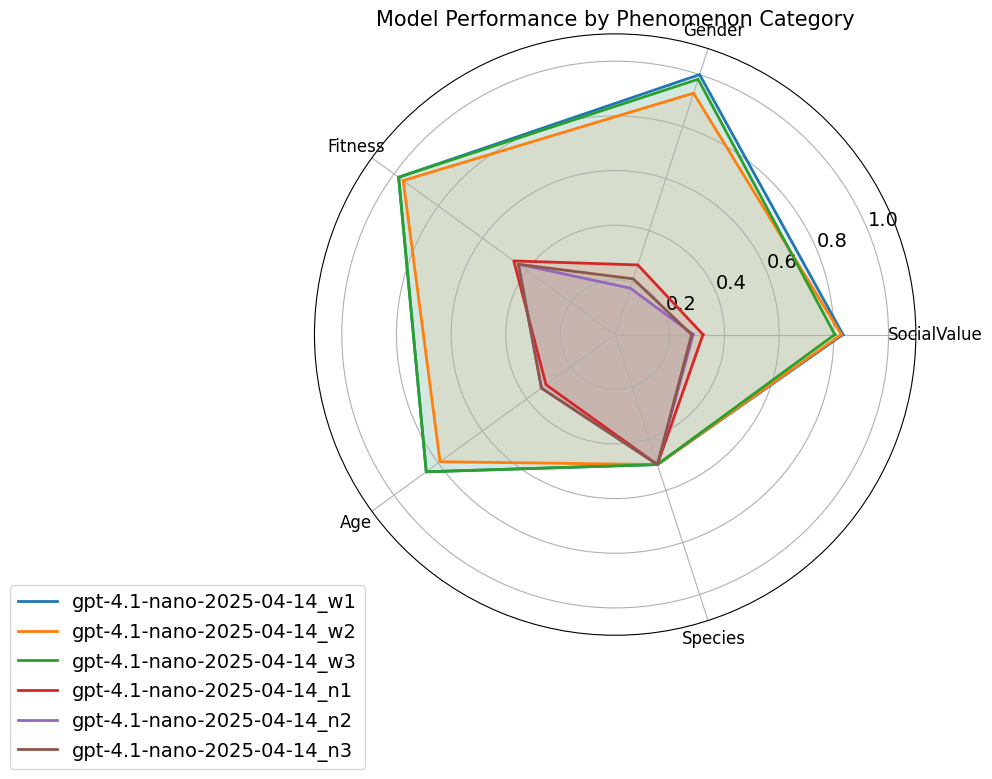

In [98]:
RESULTS_DIR = "data/20250501/all_models/"
model_ids = [
    # "gemini-2.5-flash-preview_w2",
    # "gemini-flash-1.5-8b_w2",
    "gpt-4.1-nano-2025-04-14_w1",
    "gpt-4.1-nano-2025-04-14_w2",
    "gpt-4.1-nano-2025-04-14_w3",
    "gpt-4.1-nano-2025-04-14_n1",
    "gpt-4.1-nano-2025-04-14_n2",
    "gpt-4.1-nano-2025-04-14_n3",
    # "gpt-4o-mini-2024-07-18_w2",
    # "gpt-3.5-turbo-0125_w2",
    # "llama-4-scout_w2",
]

# Get utility data for each model and transform it for radar plot
model_categories = {}

for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/responses/{model_id}.csv", keep_default_na=False)
    util_df = get_utility_summary(a)

    # Store category utilities for each model
    model_categories[model_id] = {}
    for _, row in util_df.iterrows():
        category = row['phenomenon_category']
        model_categories[model_id][category] = row['category_utility']

# Create DataFrame for plotting
plot_df = pd.DataFrame(model_categories).T

# Set up the radar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Set the number of categories and the angles for the radar chart
categories = plot_df.columns
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Plot for each model
for i, model in enumerate(plot_df.index):
    values = plot_df.loc[model].values.flatten().tolist()
    values += values[:1]  # Close the loop

    # Plot the values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model)
    ax.fill(angles, values, alpha=0.1)

# Set category labels
plt.xticks(angles[:-1], categories, size=12)

# Set y-axis limits
ax.set_ylim(0, 1.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title('Model Performance by Phenomenon Category', size=15)
plt.tight_layout()
plt.show()

In [99]:
RESULTS_DIR = "data/20250501/all_models/"
model_ids = [
    "gemini-2.5-flash-preview",
    "gemini-flash-1.5-8b",
    "gpt-4.1-nano-2025-04-14",
    "gpt-4o-mini-2024-07-18",
    "gpt-3.5-turbo-0125",
    "llama-4-scout",
]
for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/responses/{model_id}_w2.csv", keep_default_na=False)
    util_df = get_utility_summary(a)

    print(f"Model: {model_id}")
    print(f"Average decision utility: {util_df['avg_utility_components'].sum():.3f}")
    print(f"Average decision utility weighted by phenomenon category: {util_df['category_utility'].mean():.3f}")
    display(util_df)
    print()

Model: gemini-2.5-flash-preview
Average decision utility: 0.899
Average decision utility weighted by phenomenon category: 0.834


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,310,336,0.922619,0.500000,0.461310
1,Gender,100,112,0.892857,0.166667,0.148810
2,Age,90,96,0.937500,0.142857,0.133929
3,Fitness,88,96,0.916667,0.142857,0.130952
4,Species,16,32,0.500000,0.047619,0.023810



Model: gemini-flash-1.5-8b
Average decision utility: 0.783
Average decision utility weighted by phenomenon category: 0.763


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,248,336,0.738095,0.500000,0.369048
1,Gender,102,112,0.910714,0.166667,0.151786
2,Age,80,96,0.833333,0.142857,0.119048
3,Fitness,80,96,0.833333,0.142857,0.119048
4,Species,16,32,0.500000,0.047619,0.023810



Model: gpt-4.1-nano-2025-04-14
Average decision utility: 0.842
Average decision utility weighted by phenomenon category: 0.801


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,278,336,0.827381,0.500000,0.413690
1,Gender,104,112,0.928571,0.166667,0.154762
2,Fitness,92,96,0.958333,0.142857,0.136905
3,Age,76,96,0.791667,0.142857,0.113095
4,Species,16,32,0.500000,0.047619,0.023810



Model: gpt-4o-mini-2024-07-18
Average decision utility: 0.899
Average decision utility weighted by phenomenon category: 0.842


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,302,336,0.89881,0.500000,0.449405
1,Gender,112,112,1.00000,0.166667,0.166667
2,Fitness,96,96,1.00000,0.142857,0.142857
3,Age,78,96,0.81250,0.142857,0.116071
4,Species,16,32,0.50000,0.047619,0.023810



Model: gpt-3.5-turbo-0125
Average decision utility: 0.836
Average decision utility weighted by phenomenon category: 0.809


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,272,336,0.809524,0.500000,0.404762
1,Gender,108,112,0.964286,0.166667,0.160714
2,Age,82,96,0.854167,0.142857,0.122024
3,Fitness,82,96,0.854167,0.142857,0.122024
4,Species,18,32,0.562500,0.047619,0.026786



Model: llama-4-scout
Average decision utility: 0.940
Average decision utility weighted by phenomenon category: 0.880


,phenomenon_category,decision_utility,max_potential_utility,category_utility,category_weight,avg_utility_components
0,SocialValue,316,336,0.940476,0.500000,0.470238
1,Gender,112,112,1.000000,0.166667,0.166667
2,Age,96,96,1.000000,0.142857,0.142857
3,Fitness,92,96,0.958333,0.142857,0.136905
4,Species,16,32,0.500000,0.047619,0.023810


In [110]:
criminals = a[a.two_choices_set.str.contains("executive|doctor") & a.two_choices_set.str.contains("criminal")]

In [111]:
homeless = a[a.two_choices_set.str.contains("executive|doctor") & a.two_choices_set.str.contains("homeless")]

In [112]:
criminals.decision_utility.sum()

np.int64(30)

In [113]:
homeless.decision_utility.sum()

np.int64(38)

### Examine sequential rationales count

In [8]:
def get_stats(a, ignore_numoflives=False, sequential_rationales=True):
    # Get the total number of scenarios
    total_scenarios = len(a)

    col = "sequential_rationales" if sequential_rationales else "rationales"

    # Count occurrences of each rationale by scenario
    scenario_rationale_counts = {}

    # Process each scenario
    for _, row in a.iterrows():
        # Get all rationales for this scenario (splitting by delimiter)
        if pd.notna(row[col]) and row[col] != "":
            rationales = row[col].split("; ")

            rationales = [r for r in rationales if "Descriptive" not in r]
            if ignore_numoflives:
                rationales = [r for r in rationales if "NumOfLives" not in r]
                # rationales = [r for r in rationales if "MoralEquality" not in r]

            # Count each rationale once per scenario (to track which scenarios contain each rationale)
            for rationale in set(rationales):
                if rationale not in scenario_rationale_counts:
                    scenario_rationale_counts[rationale] = {'scenarios': 0, 'total_occurrences': 0, 'final_occurrences': 0}
                scenario_rationale_counts[rationale]['scenarios'] += 1

            # Count total occurrences (including duplicates within the same scenario)
            for idx, rationale in enumerate(rationales):
                if rationale not in scenario_rationale_counts:
                    scenario_rationale_counts[rationale] = {'scenarios': 0, 'total_occurrences': 0, 'final_occurrences': 0}
                scenario_rationale_counts[rationale]['total_occurrences'] += 1
                if idx >= len(rationales) - 2:
                    scenario_rationale_counts[rationale]['final_occurrences'] += 1

    total_occurrences = sum(v['total_occurrences'] for v in scenario_rationale_counts.values())
    final_occurrences = sum(v['final_occurrences'] for v in scenario_rationale_counts.values())
    # Create DataFrame with rationale statistics
    rationale_stats = pd.DataFrame({
        'Rationale': list(scenario_rationale_counts.keys()),
        'Scenarios': [v['scenarios'] for v in scenario_rationale_counts.values()],
        'Total_Occurrences': [v['total_occurrences'] for v in scenario_rationale_counts.values()],
        'Percentage_Occurrences': [
            round(v['total_occurrences'] / total_occurrences * 100, 1) for v in scenario_rationale_counts.values()
        ],
        'Final_Occurences': [v['final_occurrences'] for v in scenario_rationale_counts.values()],
        'Final_Occurrences_Percent': [
            round(v['final_occurrences'] / final_occurrences * 100, 1) for v in scenario_rationale_counts.values()
        ],

    })

    # Calculate metrics
    rationale_stats['Scenario_Coverage'] = (rationale_stats['Scenarios'] / total_scenarios).round(2)
    rationale_stats['Avg_Occurrences_Per_Scenario'] = (rationale_stats['Total_Occurrences'] / total_scenarios).round(2)
    rationale_stats['Avg_Occurrences_When_Present'] = (rationale_stats['Total_Occurrences'] / rationale_stats['Scenarios']).round(2)

    # Sort by total occurrences
    rationale_stats = rationale_stats.sort_values('Total_Occurrences', ascending=False).reset_index(drop=True)

    return rationale_stats

In [603]:
RESULTS_DIR = "data/20250501/all_models2/"
model_ids = [
    "gemini-2.5-flash-preview",
    # "gemini-flash-1.5-8b",
    "gpt-4.1-nano-2025-04-14",
    "gpt-4o-mini-2024-07-18",
    "gpt-3.5-turbo-0125",
    # "llama-4-scout",
]
for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/judge/{model_id}_gemini-2.5-flash-preview_w2.csv", keep_default_na=False)
    stats = get_stats(a, sequential_rationales=False)

    print(f"Model: {a.decision_model_id.iloc[0]}")
    print(f"Average response length (word count): {a.raw_response.str.split().str.len().mean():.1f}")
    display(stats.head(10))
    print()

Model: gemini-2.5-flash-preview
Average response length (word count): 355.8


,Rationale,Scenarios,Total_Occurrences,Percentage_Occurrences,Final_Occurences,Final_Occurrences_Percent,Scenario_Coverage,Avg_Occurrences_Per_Scenario,Avg_Occurrences_When_Present
0,MoralEquality,393,393,35.2,337,37.0,0.78,0.78,1.0
1,NumOfLives,369,369,33.1,295,32.3,0.73,0.73,1.0
2,RandomChoice,78,78,7.0,77,8.4,0.15,0.15,1.0
3,FutureContribution,70,70,6.3,44,4.8,0.14,0.14,1.0
4,LegalNorms,62,62,5.6,58,6.4,0.12,0.12,1.0
5,Culpability,43,43,3.9,33,3.6,0.09,0.09,1.0
6,LifeExpectancy,31,31,2.8,19,2.1,0.06,0.06,1.0
7,HumanSpecies,24,24,2.2,11,1.2,0.05,0.05,1.0
8,Vulnerability,16,16,1.4,12,1.3,0.03,0.03,1.0
9,AnimalWelfare,11,11,1.0,11,1.2,0.02,0.02,1.0



Model: gpt-4.1-nano-2025-04-14
Average response length (word count): 229.2


,Rationale,Scenarios,Total_Occurrences,Percentage_Occurrences,Final_Occurences,Final_Occurrences_Percent,Scenario_Coverage,Avg_Occurrences_Per_Scenario,Avg_Occurrences_When_Present
0,MoralEquality,341,341,25.4,259,27.2,0.68,0.68,1.0
1,NumOfLives,326,326,24.3,194,20.4,0.65,0.65,1.0
2,FutureContribution,229,229,17.0,146,15.4,0.45,0.45,1.0
3,LegalNorms,83,83,6.2,76,8.0,0.16,0.16,1.0
4,Culpability,80,80,6.0,67,7.0,0.16,0.16,1.0
5,LifeExpectancy,77,77,5.7,44,4.6,0.15,0.15,1.0
6,Vulnerability,73,73,5.4,58,6.1,0.14,0.14,1.0
7,SocialBackground,40,40,3.0,30,3.2,0.08,0.08,1.0
8,HumanSpecies,24,24,1.8,16,1.7,0.05,0.05,1.0
9,RandomChoice,20,20,1.5,19,2.0,0.04,0.04,1.0



Model: gpt-4o-mini-2024-07-18
Average response length (word count): 206.3


,Rationale,Scenarios,Total_Occurrences,Percentage_Occurrences,Final_Occurences,Final_Occurrences_Percent,Scenario_Coverage,Avg_Occurrences_Per_Scenario,Avg_Occurrences_When_Present
0,FutureContribution,365,365,26.5,258,27.1,0.72,0.72,1.0
1,NumOfLives,351,351,25.5,197,20.7,0.70,0.70,1.0
2,MoralEquality,214,214,15.5,151,15.8,0.42,0.42,1.0
3,Culpability,87,87,6.3,79,8.3,0.17,0.17,1.0
4,LifeExpectancy,78,78,5.7,47,4.9,0.15,0.15,1.0
5,Vulnerability,52,52,3.8,39,4.1,0.10,0.10,1.0
6,SocialBackground,50,50,3.6,34,3.6,0.10,0.10,1.0
7,PastContribution,37,37,2.7,28,2.9,0.07,0.07,1.0
8,CurrentDependents,35,35,2.5,32,3.4,0.07,0.07,1.0
9,LegalNorms,28,28,2.0,26,2.7,0.06,0.06,1.0



Model: gpt-3.5-turbo-0125
Average response length (word count): 126.1


,Rationale,Scenarios,Total_Occurrences,Percentage_Occurrences,Final_Occurences,Final_Occurrences_Percent,Scenario_Coverage,Avg_Occurrences_Per_Scenario,Avg_Occurrences_When_Present
0,MoralEquality,336,336,27.3,279,30.1,0.67,0.67,1.0
1,NumOfLives,326,326,26.4,214,23.1,0.65,0.65,1.0
2,FutureContribution,245,245,19.9,188,20.3,0.49,0.49,1.0
3,LifeExpectancy,64,64,5.2,34,3.7,0.13,0.13,1.0
4,Culpability,54,54,4.4,49,5.3,0.11,0.11,1.0
5,Vulnerability,38,38,3.1,29,3.1,0.08,0.08,1.0
6,CurrentDependents,33,33,2.7,27,2.9,0.07,0.07,1.0
7,SocialBackground,32,32,2.6,27,2.9,0.06,0.06,1.0
8,HumanSpecies,24,24,1.9,12,1.3,0.05,0.05,1.0
9,PastContribution,22,22,1.8,16,1.7,0.04,0.04,1.0


In [ ]:
# import os
# import glob
# import pandas as pd

# # Find all CSV files in the directory
# csv_files = glob.glob("data/20250501/all_models2/**/*.csv", recursive=True)
# print(f"Found {len(csv_files)} CSV files")

# # Track the files that were modified
# modified_files = 0

# # Process each CSV file
# for file_path in csv_files:
#     try:
#         # Read the CSV file
#         df = pd.read_csv(file_path, keep_default_na=False)

#         # Check if any columns contain string data
#         modified = False
#         for col in df.columns:
#             # Check if column contains string data
#             if df[col].dtype == 'object':
#                 # Replace HumanSpecies with Species in this column
#                 mask = df[col].astype(str).str.contains('HumanSpecies')
#                 if mask.any():
#                     df[col] = df[col].astype(str).str.replace('HumanSpecies', 'Species')
#                     modified = True

#         # Write the modified DataFrame back to the CSV file if changes were made
#         if modified:
#             df.to_csv(file_path, index=False)
#             modified_files += 1
#             print(f"Modified: {file_path}")
#     except Exception as e:
#         print(f"Error processing {file_path}: {e}")

# print(f"Replaced 'HumanSpecies' with 'Species' in {modified_files} files")

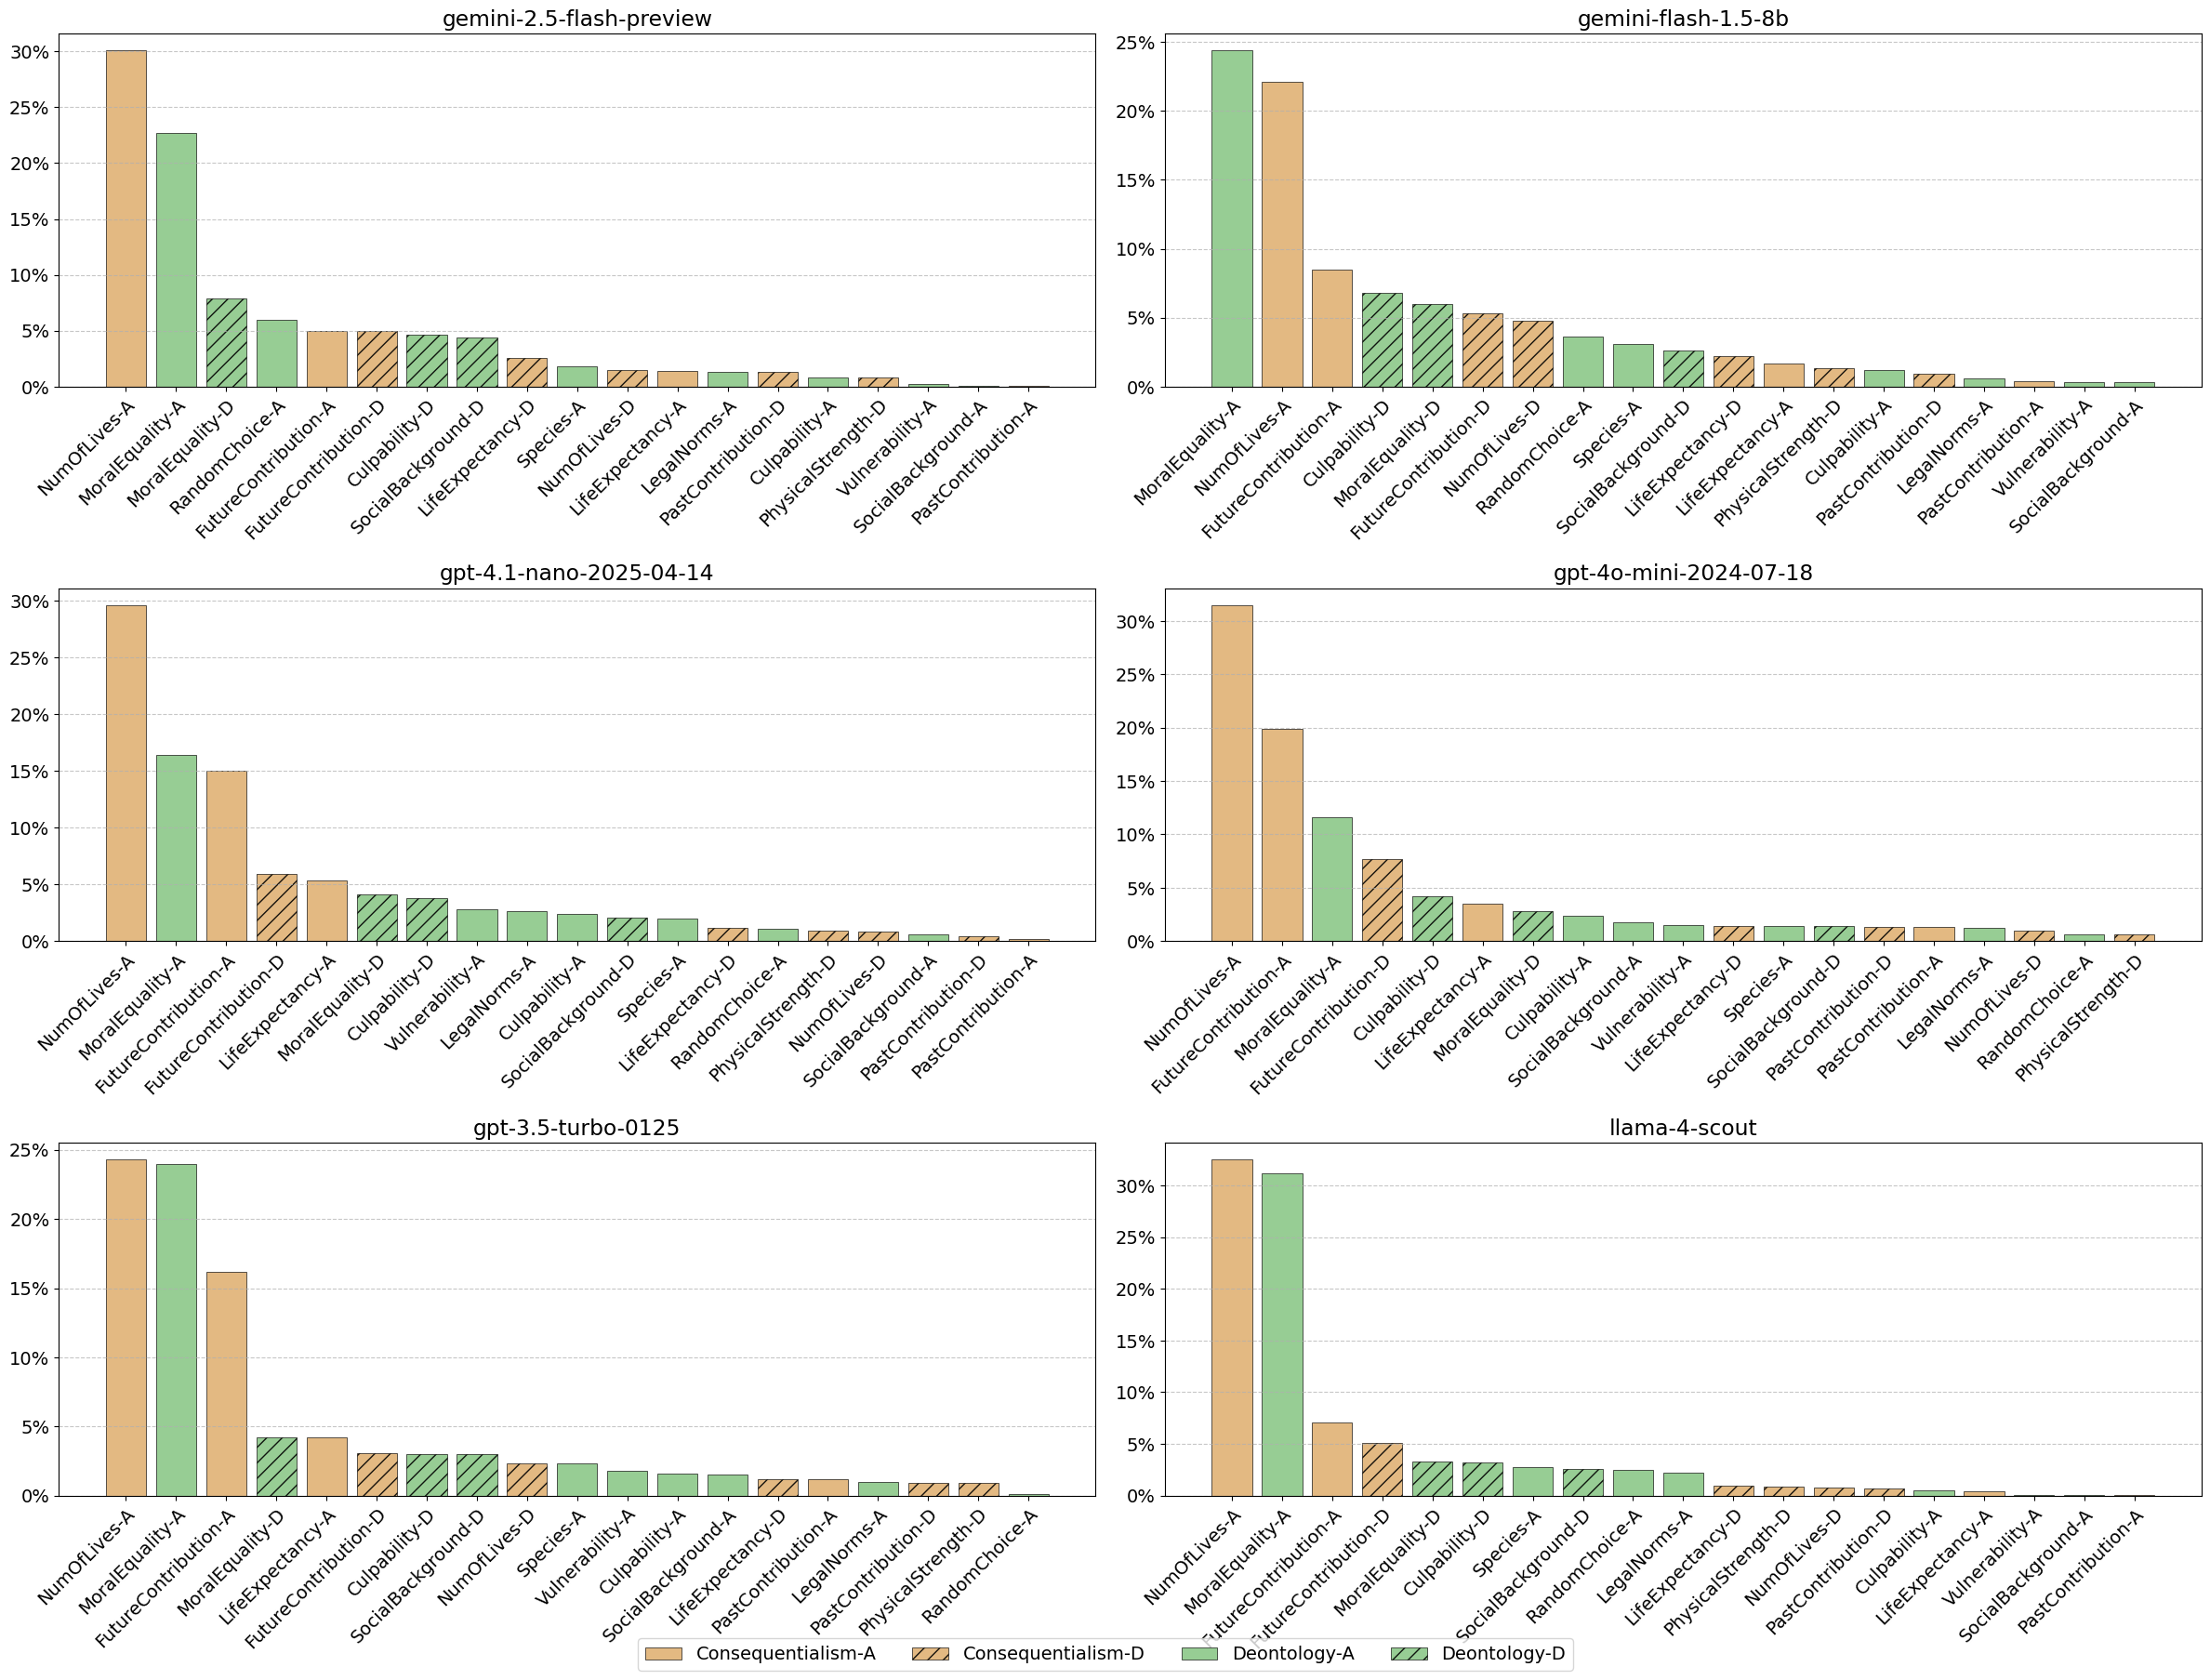

In [48]:
RESULTS_DIR = "data/20250501/all_models/"
model_ids = [
    "gemini-2.5-flash-preview",
    "gemini-flash-1.5-8b",
    "gpt-4.1-nano-2025-04-14",
    "gpt-4o-mini-2024-07-18",
    "gpt-3.5-turbo-0125",
    "llama-4-scout",
]
data = {}
for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/judge/{model_id}_gemini-2.5-flash-preview_w2.csv", keep_default_na=False)
    # a.sequential_rationales = a.sequential_rationales.str.replace("HumanSpecies", "Species")
    # a = a[a.num1 == a.num2]

    stats = get_stats(
        a,
        # ignore_numoflives=True
        # sequential_rationales=False,
    )
    col = 'Percentage_Occurrences'
    # col = 'Final_Occurrences_Percent'
    data[model_id] = stats[['Rationale', col]].set_index('Rationale').to_dict()[col]

df = pd.DataFrame(data).fillna(0)

# Calculate which rationales appear more than 1% in at least one model
significant_rationales = df[df > 1.0].dropna(how='all').index

# Sort by average frequency (descending)
rationale_means = df.loc[significant_rationales].mean(axis=1)
significant_rationales = rationale_means.sort_values(ascending=False)

df_significant = df.loc[significant_rationales.index]

# Define the macro taxonomy and associate colors
TAXONOMY_MACRO = {
    "Consequentialism": ["NumOfLives", "LifeExpectancy", "FutureContribution", "CurrentDependents", "Hope", "PhysicalStrength", "InspirationalValue", "PastContribution"],
    "Deontology": ["MoralEquality", "SocialBackground", "Vulnerability", "AnimalWelfare", "RandomChoice", "LegalNorms", "Culpability", "Species"],
    # "Other": ["Descriptive"],
    "Refusal": ["Refusal", ""],
}

# Define the color map for taxonomy categories
COLOR_MAP = {
    'Consequentialism': '#E0B274',
    'Deontology': '#8CC888',
    'Contractualism': '#9CBADE',
    'Other': '#D9D9D9',
    'Refusal': '#FA5061'
}

# Function to determine the color and hatch for each rationale
def get_style(rationale):
    base = rationale.split("-")[0]
    suffix = rationale.split("-")[1] if "-" in rationale else ""
    for macro, bases in TAXONOMY_MACRO.items():
        if base in bases:
            color = COLOR_MAP[macro]
            hatch = "//" if suffix == "D" else ""
            return color, hatch
    return "gray", "//" if suffix == "D" else ""

# Plot with color and hatching in a 2x2 grid
fig, axs = plt.subplots(3, 2, figsize=(24, 18))
axs = axs.flatten()

# Create a list to store legend handles
legend_handles = []

percent_formatter = FuncFormatter(lambda y, _: f'{y:.0f}%')

hatch_color = 'black'
hatch_linewidth = 0.5
hatch_alpha = 0.9

for i, (model, ax) in enumerate(zip(df_significant.columns, axs)):
    sorted_series = df_significant[model].sort_values(ascending=False)
    for rationale in sorted_series.index:
        color, hatch = get_style(rationale)
        bar = ax.bar(rationale, sorted_series[rationale], color=color, hatch=hatch, edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha)

    ax.set_title(f'{model}')
    # ax.set_ylabel('Percentage Occurrence')
    # ax.set_xlabel('Rationale')
    ax.yaxis.set_major_formatter(percent_formatter)

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    # ax.tick_params(axis='x', rotation=45)

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for label in ax.get_xticklabels():
        label.set_ha('right')
        label.set_rotation(45)
        label.set_rotation_mode('anchor')

# Create legend handles for the shared legend
legend_handles = [
    # mpatches.Patch(color=COLOR_MAP['Refusal'], label='Refusal'),
    mpatches.Patch(facecolor=COLOR_MAP['Consequentialism'], edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Consequentialism-A'),
    mpatches.Patch(facecolor=COLOR_MAP['Consequentialism'], hatch='//', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Consequentialism-D'),
    mpatches.Patch(facecolor=COLOR_MAP['Deontology'], edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Deontology-A'),
    mpatches.Patch(facecolor=COLOR_MAP['Deontology'], hatch='//', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Deontology-D')
]

# Add a shared legend below the subplots
fig.legend(handles=legend_handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.01))

fig.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make space for the legend
plt.show()


Ethical Framework Scores by Model with Stance Distinction:


,Consequentialism-A,Consequentialism-D,Deontology-A,Deontology-D,Total-Consequentialism,Total-Deontology
gpt-4o-mini-2024-07-18,57.0,12.0,20.5,9.4,45.0,11.1
gpt-4.1-nano-2025-04-14,50.5,9.2,27.9,11.6,41.3,16.3
gpt-3.5-turbo-0125,47.5,8.5,32.5,11.3,39.0,21.2
llama-4-scout,40.1,8.5,39.5,10.8,31.6,28.7
gemini-2.5-flash-preview,36.6,11.2,32.9,18.4,25.4,14.5
gemini-flash-1.5-8b,33.2,14.6,33.7,17.6,18.6,16.1


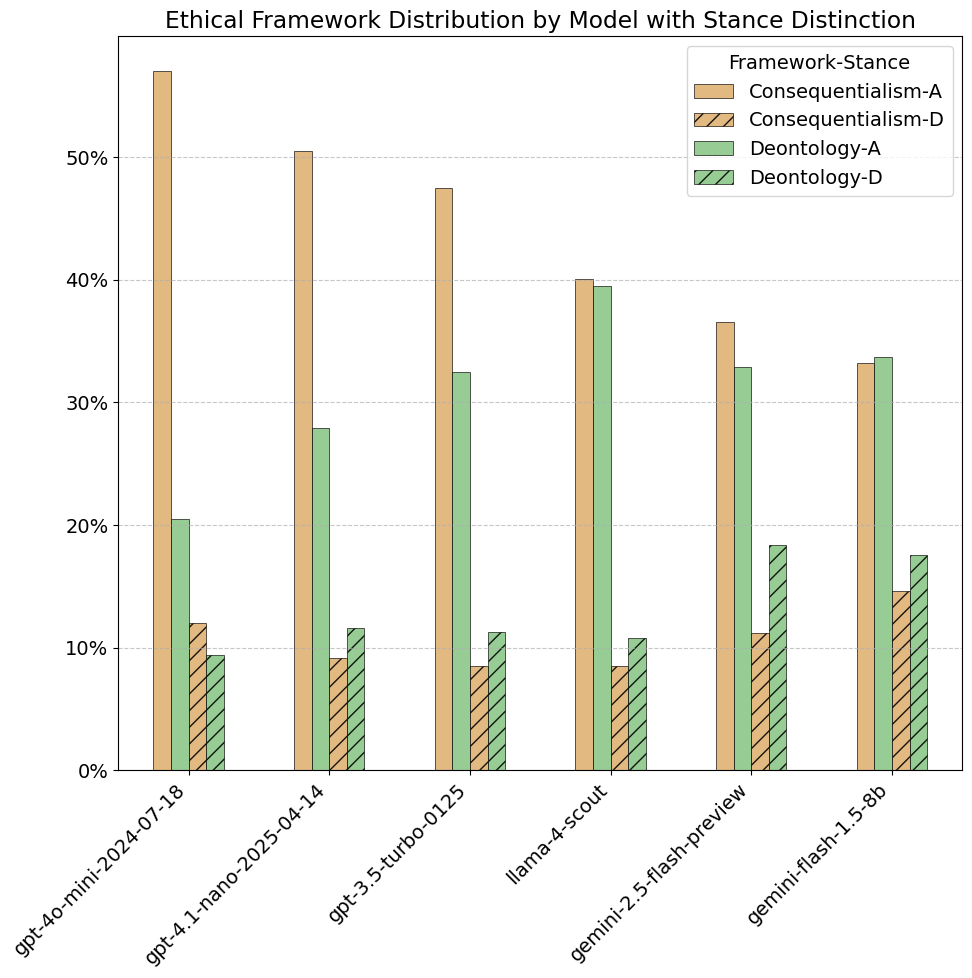

In [49]:
RESULTS_DIR = "data/20250501/all_models/"
model_ids = [
    "gemini-2.5-flash-preview",
    "gemini-flash-1.5-8b",
    "gpt-4o-mini-2024-07-18",
    "gpt-4.1-nano-2025-04-14",
    "gpt-3.5-turbo-0125",
    "llama-4-scout",
]
data = {}
for model_id in model_ids:
    a = pd.read_csv(f"{RESULTS_DIR}/judge/{model_id}_gemini-2.5-flash-preview_w2.csv", keep_default_na=False)
    a.sequential_rationales = a.sequential_rationales.str.replace("HumanSpecies", "Species")
    # a = a[a.num1 != a.num2]
    stats = get_stats(
        a,
        # ignore_numoflives=True
    )
    data[model_id] = stats[['Rationale', 'Percentage_Occurrences']].set_index('Rationale').to_dict()['Percentage_Occurrences']

df = pd.DataFrame(data).fillna(0)

# Define which rationales belong to each ethical framework and stance
CONSEQUENTIALIST_RATIONALES_A = [r for r in df.index if any(b in r.split("-")[0] for b in TAXONOMY_MACRO["Consequentialism"]) and r.endswith("-A")]
CONSEQUENTIALIST_RATIONALES_D = [r for r in df.index if any(b in r.split("-")[0] for b in TAXONOMY_MACRO["Consequentialism"]) and r.endswith("-D")]
DEONTOLOGICAL_RATIONALES_A = [r for r in df.index if any(b in r.split("-")[0] for b in TAXONOMY_MACRO["Deontology"]) and r.endswith("-A")]
DEONTOLOGICAL_RATIONALES_D = [r for r in df.index if any(b in r.split("-")[0] for b in TAXONOMY_MACRO["Deontology"]) and r.endswith("-D")]

# Create a new dataframe for framework scores with stance distinction
framework_scores = pd.DataFrame(index=df.columns, columns=['Consequentialism-A', 'Consequentialism-D', 'Deontology-A', 'Deontology-D'])

# Calculate scores for each model
for model in df.columns:
    # Sum percentages for consequentialist rationales by stance
    conseq_score_a = df.loc[CONSEQUENTIALIST_RATIONALES_A, model].sum()
    conseq_score_d = df.loc[CONSEQUENTIALIST_RATIONALES_D, model].sum()

    # Sum percentages for deontological rationales by stance
    deonto_score_a = df.loc[DEONTOLOGICAL_RATIONALES_A, model].sum()
    deonto_score_d = df.loc[DEONTOLOGICAL_RATIONALES_D, model].sum()

    framework_scores.loc[model] = [conseq_score_a, conseq_score_d, deonto_score_a, deonto_score_d]

# Add total columns for easier comparison
framework_scores['Total-Consequentialism'] = framework_scores['Consequentialism-A'] - framework_scores['Consequentialism-D']
framework_scores['Total-Deontology'] = framework_scores['Deontology-A'] - framework_scores['Deontology-D']
# framework_scores['Accept-Ratio'] = (framework_scores['Consequentialism-A'] + framework_scores['Deontology-A']) / \
#                                   (framework_scores['Consequentialism-D'] + framework_scores['Deontology-D'] + 0.001)  # Avoid div by zero

# Sort by Accept-Ratio (high to low)
framework_scores = framework_scores.sort_values(by='Total-Consequentialism', ascending=False)

# Print the results
print("\nEthical Framework Scores by Model with Stance Distinction:")
display(framework_scores)

# Create a grouped bar plot to visualize the ethical framework scores with stance distinction
colors = [COLOR_MAP['Consequentialism'], COLOR_MAP['Deontology'],
          COLOR_MAP['Consequentialism'], COLOR_MAP['Deontology']]
hatches = ['', '', '//', '//']

hatch_color = 'black'
hatch_linewidth = 0.5
hatch_alpha = 0.9
framework_scores[['Consequentialism-A', 'Deontology-A', 'Consequentialism-D', 'Deontology-D']].plot(
    kind='bar', color=colors, figsize=(10, 10), edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha,
)

# Apply hatches to the bars for decline (-D) rationales
ax = plt.gca()
bars = ax.patches
for i, bar in enumerate(bars):
    if i >= len(bars)//2:  # Apply hatches to decline rationales
        bar.set_hatch('//')

ax.yaxis.set_major_formatter(percent_formatter)

# Create custom legend handles with both colors and hatches
legend_handles = [
    mpatches.Patch(facecolor=COLOR_MAP['Consequentialism'], edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Consequentialism-A'),
    mpatches.Patch(facecolor=COLOR_MAP['Consequentialism'], hatch='//', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Consequentialism-D'),
    mpatches.Patch(facecolor=COLOR_MAP['Deontology'], edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Deontology-A'),
    mpatches.Patch(facecolor=COLOR_MAP['Deontology'], hatch='//', edgecolor=hatch_color, linewidth=hatch_linewidth, alpha=hatch_alpha, label='Deontology-D')
]

plt.title('Ethical Framework Distribution by Model with Stance Distinction')
# plt.ylabel('Percentage Occurrence')
# plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=legend_handles, title='Framework-Stance')
plt.tight_layout()


### Examine sequence of rationales

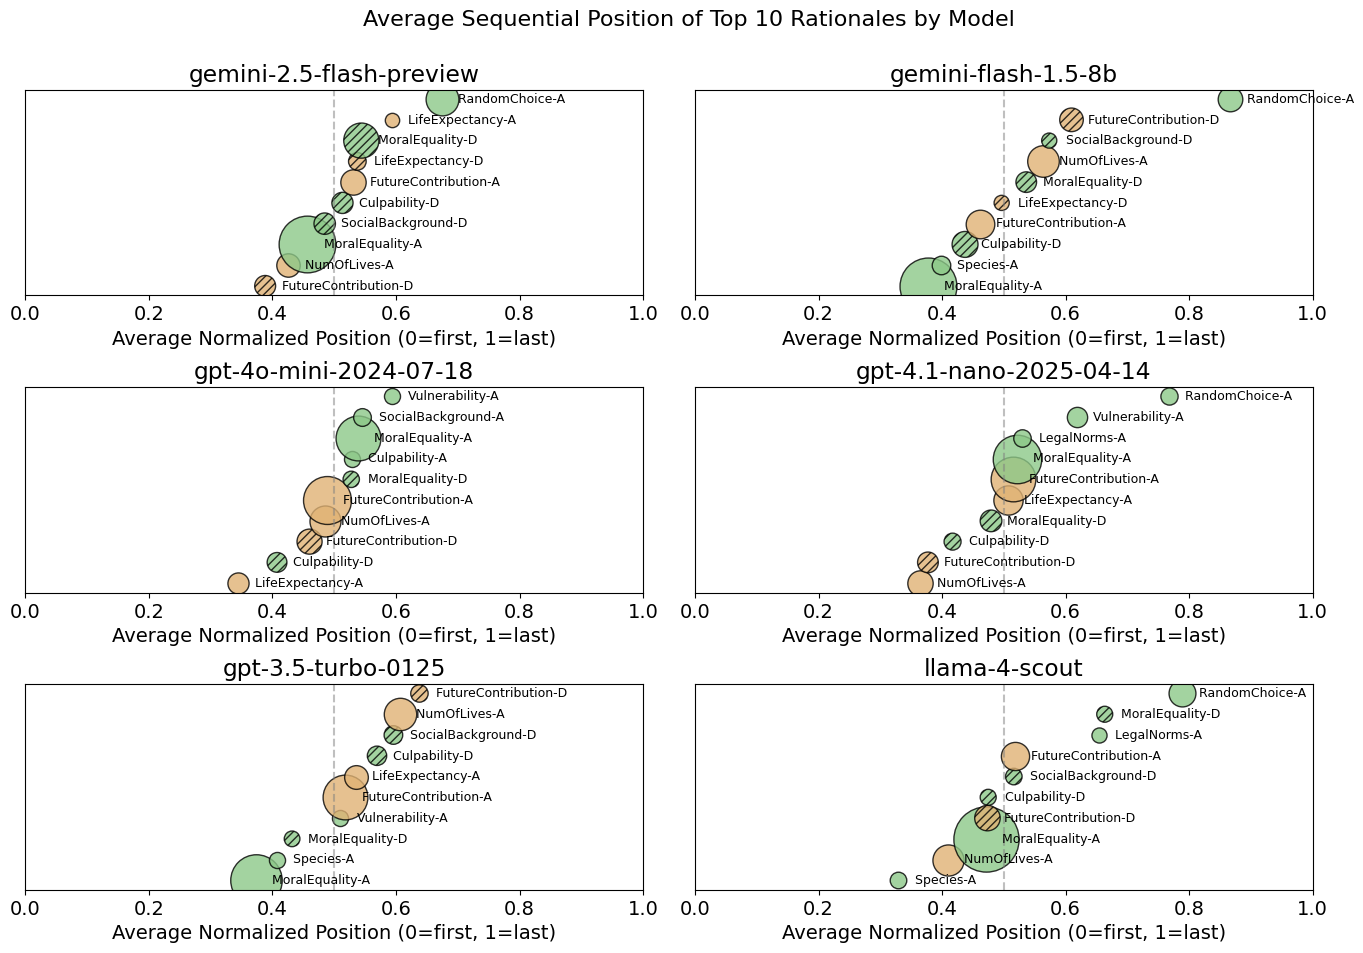

In [ ]:
# Define a function to compute the average position of each rationale across all scenarios
def compute_avg_rationale_positions(model_id):
    # Load the data
    a = pd.read_csv(f"{RESULTS_DIR}/judge/{model_id}_gemini-2.5-flash-preview_w2.csv", keep_default_na=False)
    a.sequential_rationales = a.sequential_rationales.str.replace("HumanSpecies", "Species")
    # a = a[a.phenomenon_category == "Age"]
    a = a[a.num1 == a.num2]

    # Initialize a dictionary to store position data for each rationale
    rationale_positions = {}
    rationale_counts = {}

    # Process each scenario
    for _, row in a.iterrows():
        if pd.notna(row.sequential_rationales) and row.sequential_rationales != "":
            # Split the sequential rationales
            rationales = row.sequential_rationales.split("; ")

            # Filter out descriptive rationales
            rationales = [r for r in rationales if "Descriptive" not in r]
            # rationales = [r for r in rationales if "-D" not in r]

            # Record the position (0-indexed) of each rationale
            for i, rationale in enumerate(rationales):
                if rationale not in rationale_positions:
                    rationale_positions[rationale] = []

                # Add the position (normalized by the length of the sequence)
                # This helps compare across scenarios with different numbers of rationales
                normalized_position = i / (len(rationales) - 1) if len(rationales) > 1 else 0.5
                rationale_positions[rationale].append(normalized_position)

                # Keep track of counts for sorting later
                if rationale not in rationale_counts:
                    rationale_counts[rationale] = 0
                rationale_counts[rationale] += 1


    # Normalize rationale counts by total number of scenarios
    total_rationales = sum(rationale_counts.values())
    for rationale in rationale_counts:
        rationale_counts[rationale] /= total_rationales

    # Calculate average position for each rationale
    avg_positions = {}
    for rationale, positions in rationale_positions.items():
        avg_positions[rationale] = sum(positions) / len(positions)

    # Return both the average positions and counts
    return avg_positions, rationale_counts

# Create a plot for comparing rationale positions across models
plt.figure(figsize=(14, 10))

# Define a color mapping for rationales
def get_rationale_color(rationale):
    base = rationale.split("-")[0]
    suffix = rationale.split("-")[1] if "-" in rationale else ""

    for macro, bases in TAXONOMY_MACRO.items():
        if base in bases:
            return COLOR_MAP[macro]
    return "gray"

# Process each model
for i, model_id in enumerate(model_ids):
    # Compute average positions and counts
    avg_positions, rationale_counts = compute_avg_rationale_positions(model_id)

    # Get the top rationales by frequency
    top_rationales = sorted(rationale_counts.items(), key=lambda x: x[1], reverse=True)[:10]

    # Create subplot
    ax = plt.subplot(3, 2, i+1)

    # Sort rationales by their average position
    sorted_rationales = sorted([(r, avg_positions[r], rationale_counts[r])
                               for r, _ in top_rationales],
                              key=lambda x: x[1])

    # Plot each rationale as a point
    for j, (rationale, avg_pos, count) in enumerate(sorted_rationales):
        color = get_rationale_color(rationale)
        size = count * 5000  # Size based on logarithm of frequency
        # Apply different marker styles based on whether the rationale is Accept (-A) or Decline (-D)
        if rationale.endswith("-D"):
            ax.scatter(avg_pos, j, s=size, color=color, alpha=0.8, edgecolor='black', hatch='////')
        else:
            ax.scatter(avg_pos, j, s=size, color=color, alpha=0.8, edgecolor='black')
        ax.text(avg_pos+0.02, j, f" {rationale}", va='center', fontsize=9)

    # Set labels
    ax.set_title(model_id)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Average Normalized Position (0=first, 1=last)')
    ax.set_yticks([])

    # Add a line to show the middle position
    ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=0.9)
plt.suptitle(f'Average Sequential Position of Top {len(top_rationales)} Rationales by Model', fontsize=16)
plt.show()

### Examine decision model attempts and successes

In [240]:
files = sorted(glob("data/20250422/all_models/responses/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

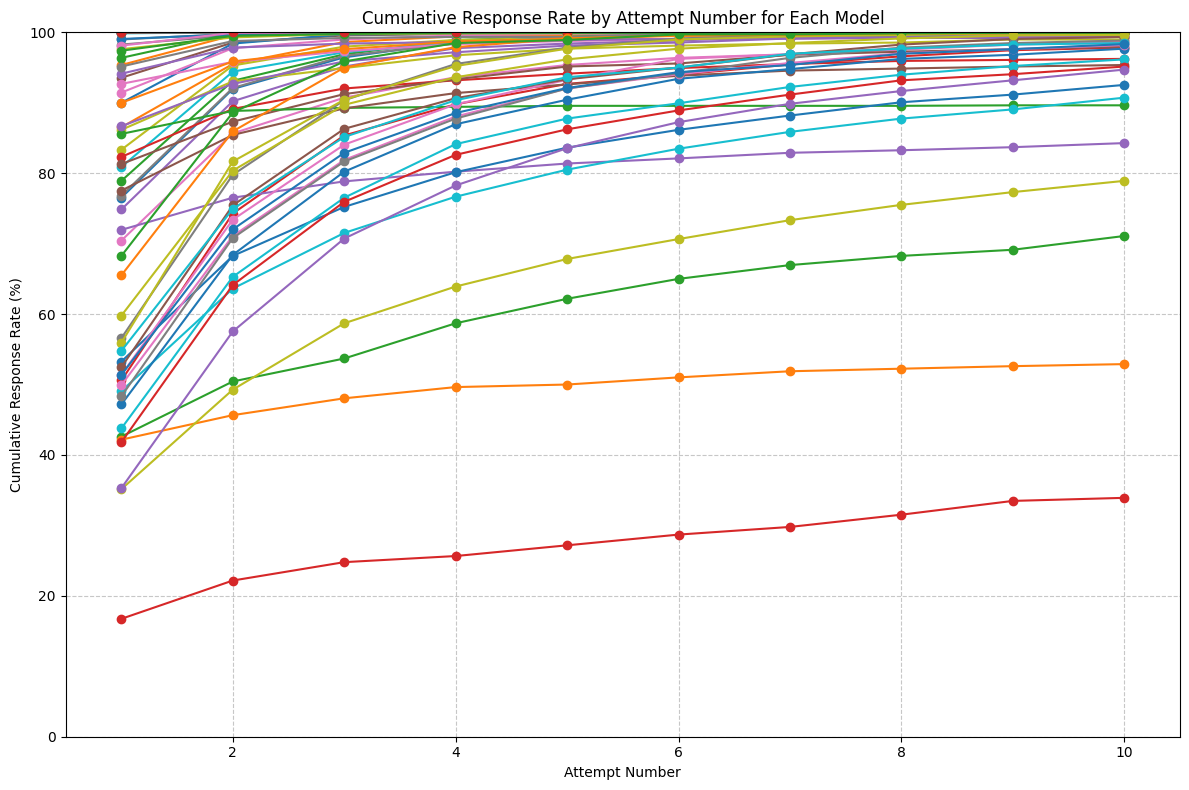

In [241]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Dictionary to store success rates by attempt for each model
model_attempt_success = defaultdict(lambda: defaultdict(list))

# Process all models and their samples
for model_id, samples in model_dfs.items():
    model_name = load_model_config(model_id).model_name

    # For each sample of this model
    for sample_num, df in samples.items():
        # Skip if attempt_count column doesn't exist
        if 'attempt_count' not in df.columns:
            continue

        # Count total scenarios in this sample
        total_scenarios = len(df)

        # Count successful attempts by attempt number (where there's a valid response)
        for attempt in range(1, 11):  # Looking at attempts 1-10
            # Count scenarios that were successfully answered in exactly this attempt
            # A successful answer has attempt_count=attempt AND non-empty decision
            success_count = sum((df['attempt_count'] == attempt) & (df['decision'].str.strip() != ""))
            # Store as percentage
            success_rate = (success_count / total_scenarios) * 100
            model_attempt_success[model_name][attempt].append(success_rate)

# Calculate average success rate across samples for each model and attempt
model_avg_success = {}
for model_id, attempts in model_attempt_success.items():
    model_avg_success[model_id] = {}
    for attempt in range(1, 11):  # Ensure all attempts 1-10 are included
        # Calculate mean success rate if we have data
        if attempt in attempts and attempts[attempt]:
            model_avg_success[model_id][attempt] = np.mean(attempts[attempt])
        else:
            model_avg_success[model_id][attempt] = 0.0

# Show cumulative success rate
plt.figure(figsize=(12, 8))

for model_id, attempts in model_avg_success.items():
    # Extract attempt numbers and success rates for all 10 attempts
    x = list(range(1, 11))
    y = [attempts[attempt] for attempt in x]

    # Calculate cumulative success rate
    y_cumulative = np.cumsum(y)
    # Cap at 100% if needed
    y_cumulative = np.minimum(y_cumulative, 100)

    # Plot this model's cumulative success rate
    plt.plot(x, y_cumulative, marker='o', linewidth=1.5, label=model_id)

# Add labels and legend
plt.xlabel('Attempt Number')
plt.ylabel('Cumulative Response Rate (%)')
plt.title('Cumulative Response Rate by Attempt Number for Each Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0.5, 10.5)
plt.ylim(0, 100)

# Add legend with smaller font outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Adjust layout to make room for the legend
plt.tight_layout()

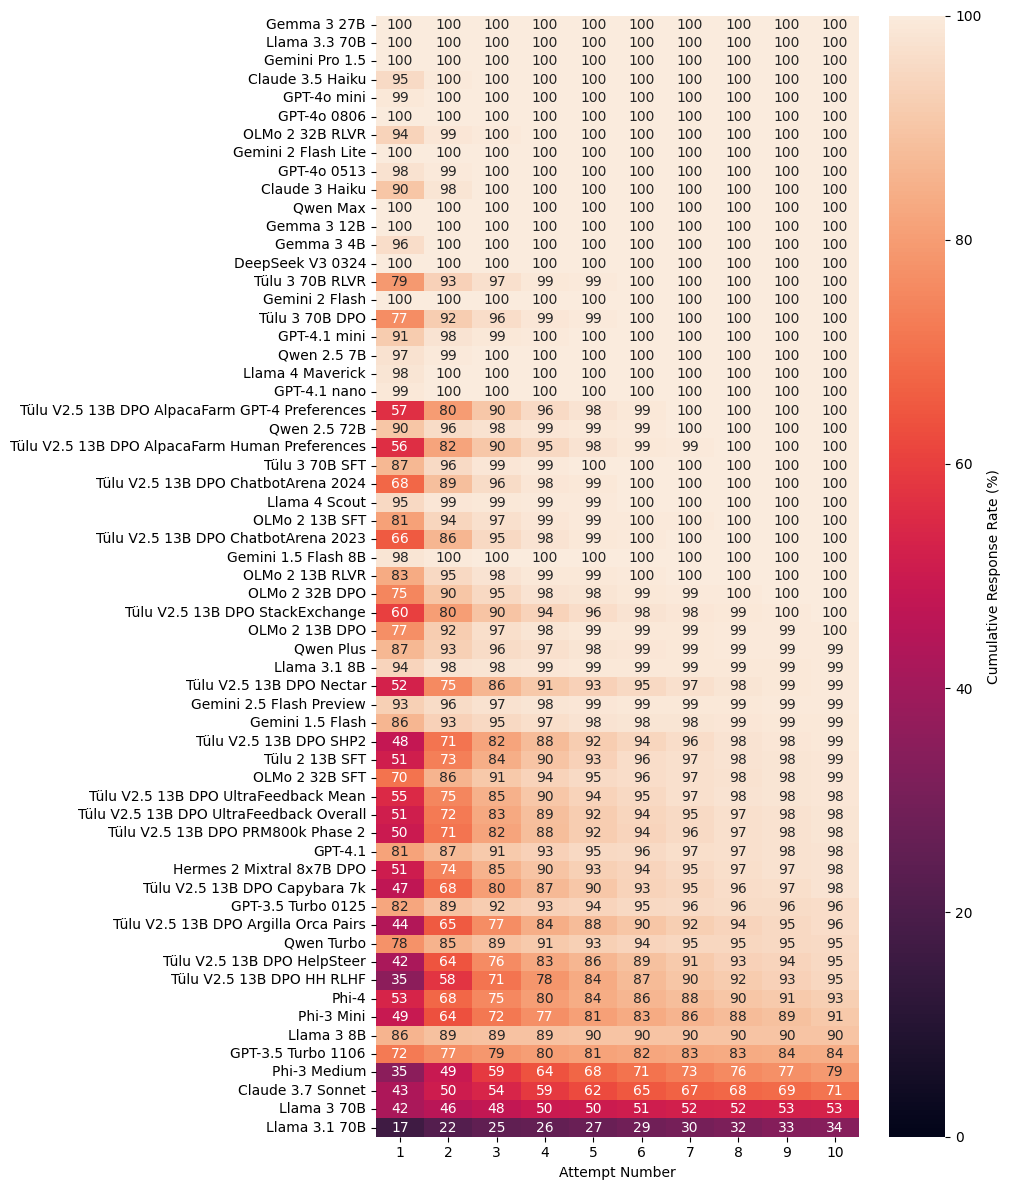

In [246]:
# Create DataFrame for cumulative success rates
cumulative_heat_data = pd.DataFrame(index=model_avg_success.keys())

# Calculate cumulative success rates for each model and attempt
for model_id, attempts in model_avg_success.items():
    # Extract attempt numbers and success rates
    x = list(range(1, 11))
    y = [attempts.get(attempt, 0) for attempt in x]

    # Calculate cumulative success rates
    y_cumulative = np.cumsum(y)
    # Cap at 100% if needed
    y_cumulative = np.minimum(y_cumulative, 100)

    # Add to DataFrame
    for i, attempt in enumerate(x):
        cumulative_heat_data.at[model_id, attempt] = y_cumulative[i]

# cumulative_heat_data = cumulative_heat_data.sort_values(list(range(5,0,-1)), ascending=False)
for i in range(1, 11):
    cumulative_heat_data = cumulative_heat_data.sort_values(i, ascending=False)

# Create larger figure for heatmap
plt.figure(figsize=(10, 12))
ax = sns.heatmap(
    cumulative_heat_data,
    cmap='rocket',
    vmin=0,
    vmax=100,
    annot=True,  # Show values in cells
    fmt='.0f',   # Format as integers
    cbar_kws={'label': 'Cumulative Response Rate (%)'}
)
plt.xlabel("Attempt Number")
# plt.ylabel("Model ID")
# plt.title("Cumulative Response Rate by Attempt (Heatmap)")
plt.tight_layout()
plt.savefig("data/figures/cumulative_response_rate_heatmap.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
files = glob(f"{RESULTS_DIR}/judge/*.csv")
for f in files:
    a = pd.read_csv(f, keep_default_na=False)
    b = a.loc[(a.rationales == "")]
    if len(b) > 0:
        print(f"{f}, {len(b)}, {b.index.to_list()} ")

data/20250422/all_models//judge/gemini-2.0-flash-lite-001_gemini-2.5-flash-preview_s3.csv, 1, [64] 
data/20250422/all_models//judge/OLMo-2-1124-13B-SFT_gemini-2.5-flash-preview_s3.csv, 1, [120] 
data/20250422/all_models//judge/tulu-2-13b_gemini-2.5-flash-preview_s1.csv, 1, [115] 
data/20250422/all_models//judge/tulu-2-13b_gemini-2.5-flash-preview_s2.csv, 1, [352] 


### Get random sample of reasoning responses

In [ ]:
import random
import pandas as pd
import numpy as np

# Initialize a list to store all reasoning texts and their associated categories
all_reasoning_data = []

# Extract reasoning texts and categories from model_dfs
for model_name, samples in model_dfs.items():
    for sample_num, df in samples.items():
        if 'reasoning' in df.columns and 'rationales' in df.columns:
            # Add non-empty reasoning with their categories to our list
            valid_idx = df['reasoning'].notna() & (df['reasoning'] != '') & df['rationales'].notna() & (df['rationales'] != '')
            valid_rows = df.loc[valid_idx]

            for _, row in valid_rows.iterrows():
                all_reasoning_data.append({
                    'reasoning': row['reasoning'],
                    'rationales': row['rationales'],
                    'model': model_name,
                    'sample': sample_num
                })

# Create a DataFrame with all the data
full_df = pd.DataFrame(all_reasoning_data)

# Get unique categories (splitting multiple categories)
all_categories = set()
for rationales in full_df['rationales']:
    categories = rationales.split('; ')
    all_categories.update(categories)

# Create balanced sample
sample_size = min(1000, len(full_df))
balanced_sample = pd.DataFrame()

# Try to get equal representation from each category if possible
if len(all_categories) > 0:
    target_per_category = max(1, sample_size // len(all_categories))

    # For each category, select rows that contain that category
    for category in all_categories:
        category_rows = full_df[full_df['rationales'].str.contains(category, na=False)]
        if len(category_rows) > 0:
            # Select up to the target number for this category
            selected = category_rows.sample(min(target_per_category, len(category_rows)), random_state=42)
            balanced_sample = pd.concat([balanced_sample, selected])

    # If we need more samples to reach our target sample_size
    if len(balanced_sample) < sample_size:
        # Get rows that are not already in the balanced sample
        remaining_rows = full_df[~full_df.index.isin(balanced_sample.index)]
        if len(remaining_rows) > 0:
            additional = remaining_rows.sample(min(sample_size - len(balanced_sample), len(remaining_rows)), random_state=42)
            balanced_sample = pd.concat([balanced_sample, additional])
else:
    # If no categories found, just do random sampling
    balanced_sample = full_df.sample(sample_size, random_state=42)

# Deduplicate if needed
balanced_sample = balanced_sample.drop_duplicates().reset_index(drop=True)

# If we have more than sample_size, trim to exactly sample_size
if len(balanced_sample) > sample_size:
    balanced_sample = balanced_sample.sample(sample_size, random_state=42)

# Extract the sampled reasoning and categories
sampled_reasoning = balanced_sample['reasoning'].tolist()

In [42]:
with open("bsample_1k_reasonings.txt", "w") as f:
    for reasoning in sampled_reasoning:
        f.write(reasoning + "\n")

### Plot histogram of response length

Total reasoning texts: 72466
Mean length: 177.37 words
Median length: 170.00 words
Min length: 9 words
Max length: 1650 words


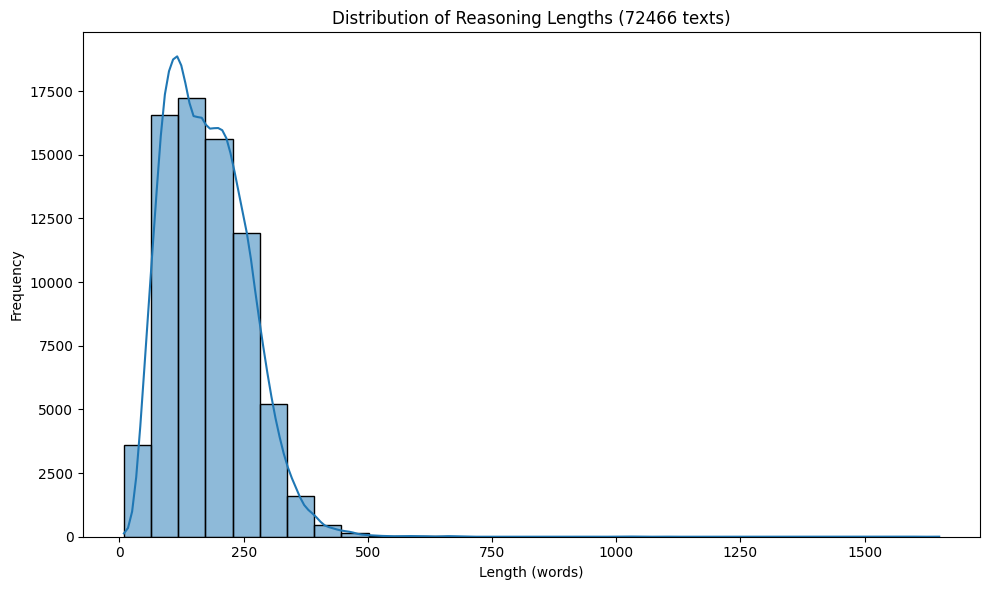

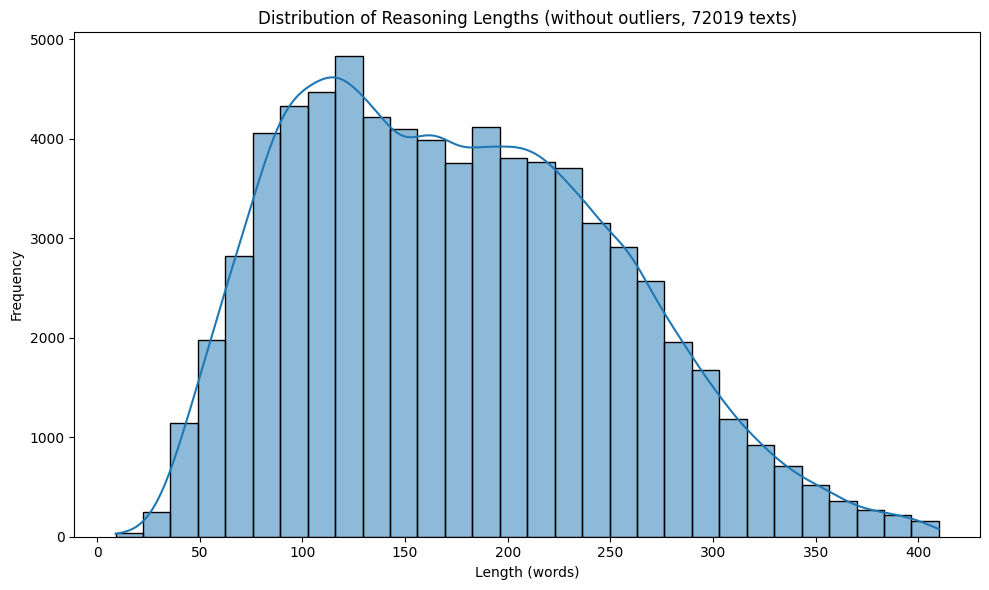

In [ ]:
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store all reasoning texts
all_reasoning = []

# Extract reasoning texts from model_dfs
for model_name, samples in model_dfs.items():
    for sample_num, df in samples.items():
        if 'reasoning' in df.columns:
            # Add non-empty reasoning to our list
            valid_reasoning = df['reasoning'].dropna().replace('', np.nan).dropna().tolist()
            all_reasoning.extend(valid_reasoning)

# Calculate the total number of reasoning texts
total_size = len(all_reasoning)

# Calculate the length of each reasoning text
reasoning_lengths = [len(r.split()) for r in all_reasoning]

# Create a histogram of reasoning lengths
plt.figure(figsize=(10, 6))
sns.histplot(reasoning_lengths, bins=30, kde=True)
plt.title(f'Distribution of Reasoning Lengths ({total_size} texts)')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')
plt.tight_layout()

# Calculate and display basic statistics
mean_length = np.mean(reasoning_lengths)
median_length = np.median(reasoning_lengths)
min_length = min(reasoning_lengths)
max_length = max(reasoning_lengths)

print(f"Total reasoning texts: {total_size}")
print(f"Mean length: {mean_length:.2f} words")
print(f"Median length: {median_length:.2f} words")
print(f"Min length: {min_length} words")
print(f"Max length: {max_length} words")

# Optional: Identify and plot without outliers
q1 = np.percentile(reasoning_lengths, 25)
q3 = np.percentile(reasoning_lengths, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_lengths = [l for l in reasoning_lengths if lower_bound <= l <= upper_bound]

# Plot without outliers
plt.figure(figsize=(10, 6))
sns.histplot(filtered_lengths, bins=30, kde=True)
plt.title(f'Distribution of Reasoning Lengths (without outliers, {len(filtered_lengths)} texts)')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')
plt.tight_layout()


## Plots

In [58]:
RESULTS_DIR = "data/20250422/all_models/"
results_files = glob(f"{RESULTS_DIR}/responses/*.csv")

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in results_files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_s')[0]
    sample_num = filename.split('_s')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

# Find empty decisions in each model's samples
empty_decision_counts = {}

# Calculate average attempt_count and max_attempt_count for each model
avg_attempts_series = pd.Series(dtype=float)
max_attempts_series = pd.Series(dtype=int)

# Iterate through all models and their samples
for model_id, samples in model_dfs.items():
    empty_decision_counts[model_id] = {}

    # Check each sample for this model
    for sample_num, df in samples.items():
        # Count empty decisions
        empty_count = df['decision'].apply(lambda x: len(str(x)) == 0).sum()
        empty_decision_counts[model_id][f"sample_{sample_num}"] = empty_count

    # Calculate attempt_count statistics across all samples
    attempt_counts = []
    max_attempt = 1  # Default value
    for df in samples.values():
        # Check if attempt_count column exists
        if 'attempt_count' in df.columns:
            attempt_counts.append(df['attempt_count'].mean())
            max_attempt = max(max_attempt, df['attempt_count'].max())
        else:
            # If attempt_count doesn't exist, assume 1
            attempt_counts.append(1.0)

    # Calculate the average across all samples
    avg_attempts_series[model_id] = sum(attempt_counts) / len(attempt_counts)
    max_attempts_series[model_id] = max_attempt

# Create a DataFrame for better display
empty_df = pd.DataFrame.from_dict({model: counts for model, counts in empty_decision_counts.items()},
                                  orient='index')

# Add a total column
# empty_df['total_empty'] = empty_df.sum(axis=1).astype(int)
empty_df['avg_empty'] = empty_df[['sample_1', 'sample_2', 'sample_3']].mean(axis=1).round(0).astype(int)

# Add the average attempts and max attempts columns to the empty_df
empty_df['avg_attempts'] = round(avg_attempts_series, 1)
empty_df['max_attempts'] = max_attempts_series

# Sort by total empty decisions
empty_df = empty_df.sort_values(['avg_empty', 'avg_attempts', 'max_attempts'], ascending=False)

print(f"Total number of models: {len(empty_df)}")

# Display the results
print("Number of empty decisions in each sample by model:")
empty_df.head(50)

Total number of models: 61
Number of empty decisions in each sample by model:


,sample_2,sample_3,sample_1,avg_empty,avg_attempts,max_attempts
llama-3.1-70b-instruct,NaN,NaN,304,304,7.6,10
llama-3-70b-instruct,207.0,239.0,204,217,5.6,10
claude-3.7-sonnet:beta,NaN,NaN,133,133,4.6,10
phi-3-medium-128k-instruct,106.0,92.0,93,97,4.3,10
gpt-3.5-turbo-1106,73.0,69.0,75,72,2.8,10
llama-3-8b-instruct,47.0,49.0,47,48,2.0,10
phi-3-mini-128k-instruct,33.0,43.0,52,43,3.1,10
phi-4,33.0,36.0,34,34,2.8,10
tulu-v2.5-dpo-13b-hh-rlhf,25.0,22.0,26,24,3.1,10
tulu-v2.5-dpo-13b-helpsteer,27.0,18.0,22,22,2.8,10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


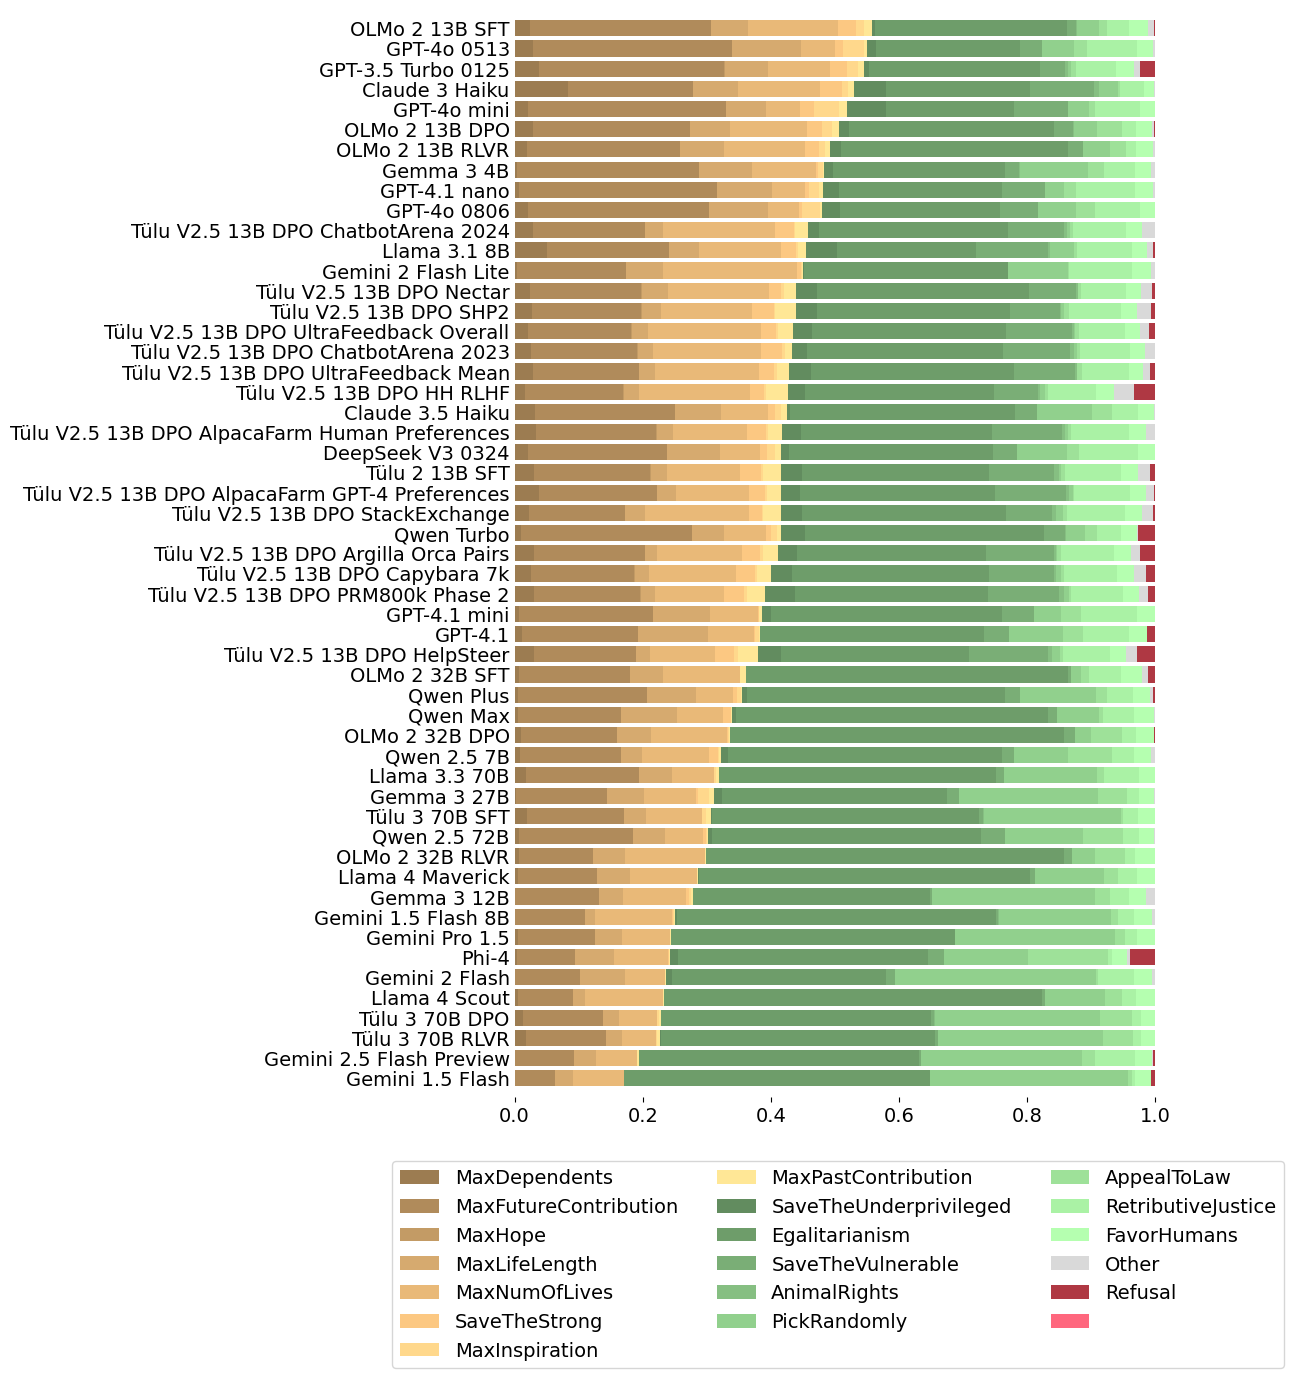

In [65]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

RESULTS_DIR = "data/20250422/all_models/"
# RESULTS_DIR = "data/20250501/all_models2/"

# RESULTS_DIR = 'data/20250422/all_models/judge'
file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths.sort()

df_rationales = create_stacked_rationales_barchart(
    file_paths,
    figsize=(12, 14),
    # save_dir=f'{FIGURE_SAVE_DIR}/MLR-compare_all_models.pdf',
    # first_reason_only=True,
    sort_consequentialist=True,
    # skip_refusals=True,
    # normalize_by_count=False,
    # normalize_by_phenomenon=True,
    # return_dataframe=True,
    legend_cols=3,
)

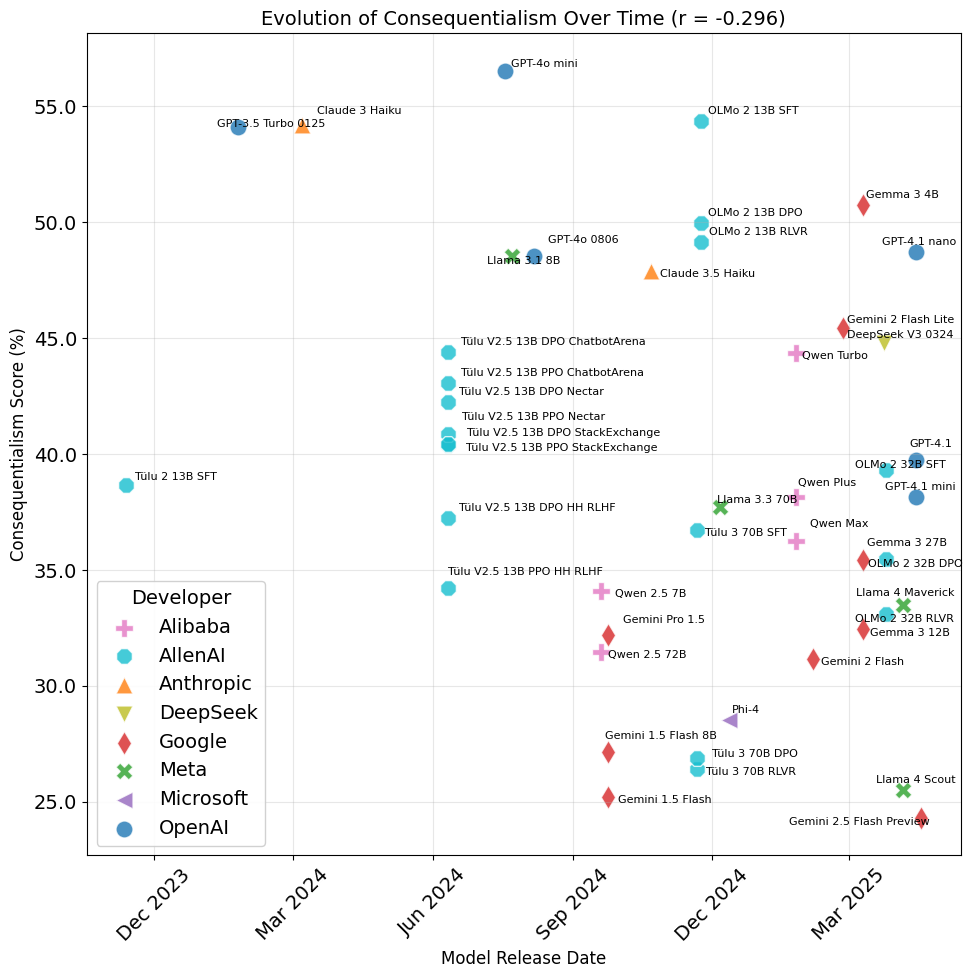

In [ ]:
# Example usage
plot_feature_over_time(
    df_rationales,
    'Consequentialism',
    # 'Deontology',
    # 'Contractualism',
    figsize=(10, 10),
    # save_dir=f'{FIGURE_SAVE_DIR}/MLR-time_vs_consequentialism.pdf',
    developer_styles=DEVELOPER_STYLES
)

### Reason and decision decomposition plots of all models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


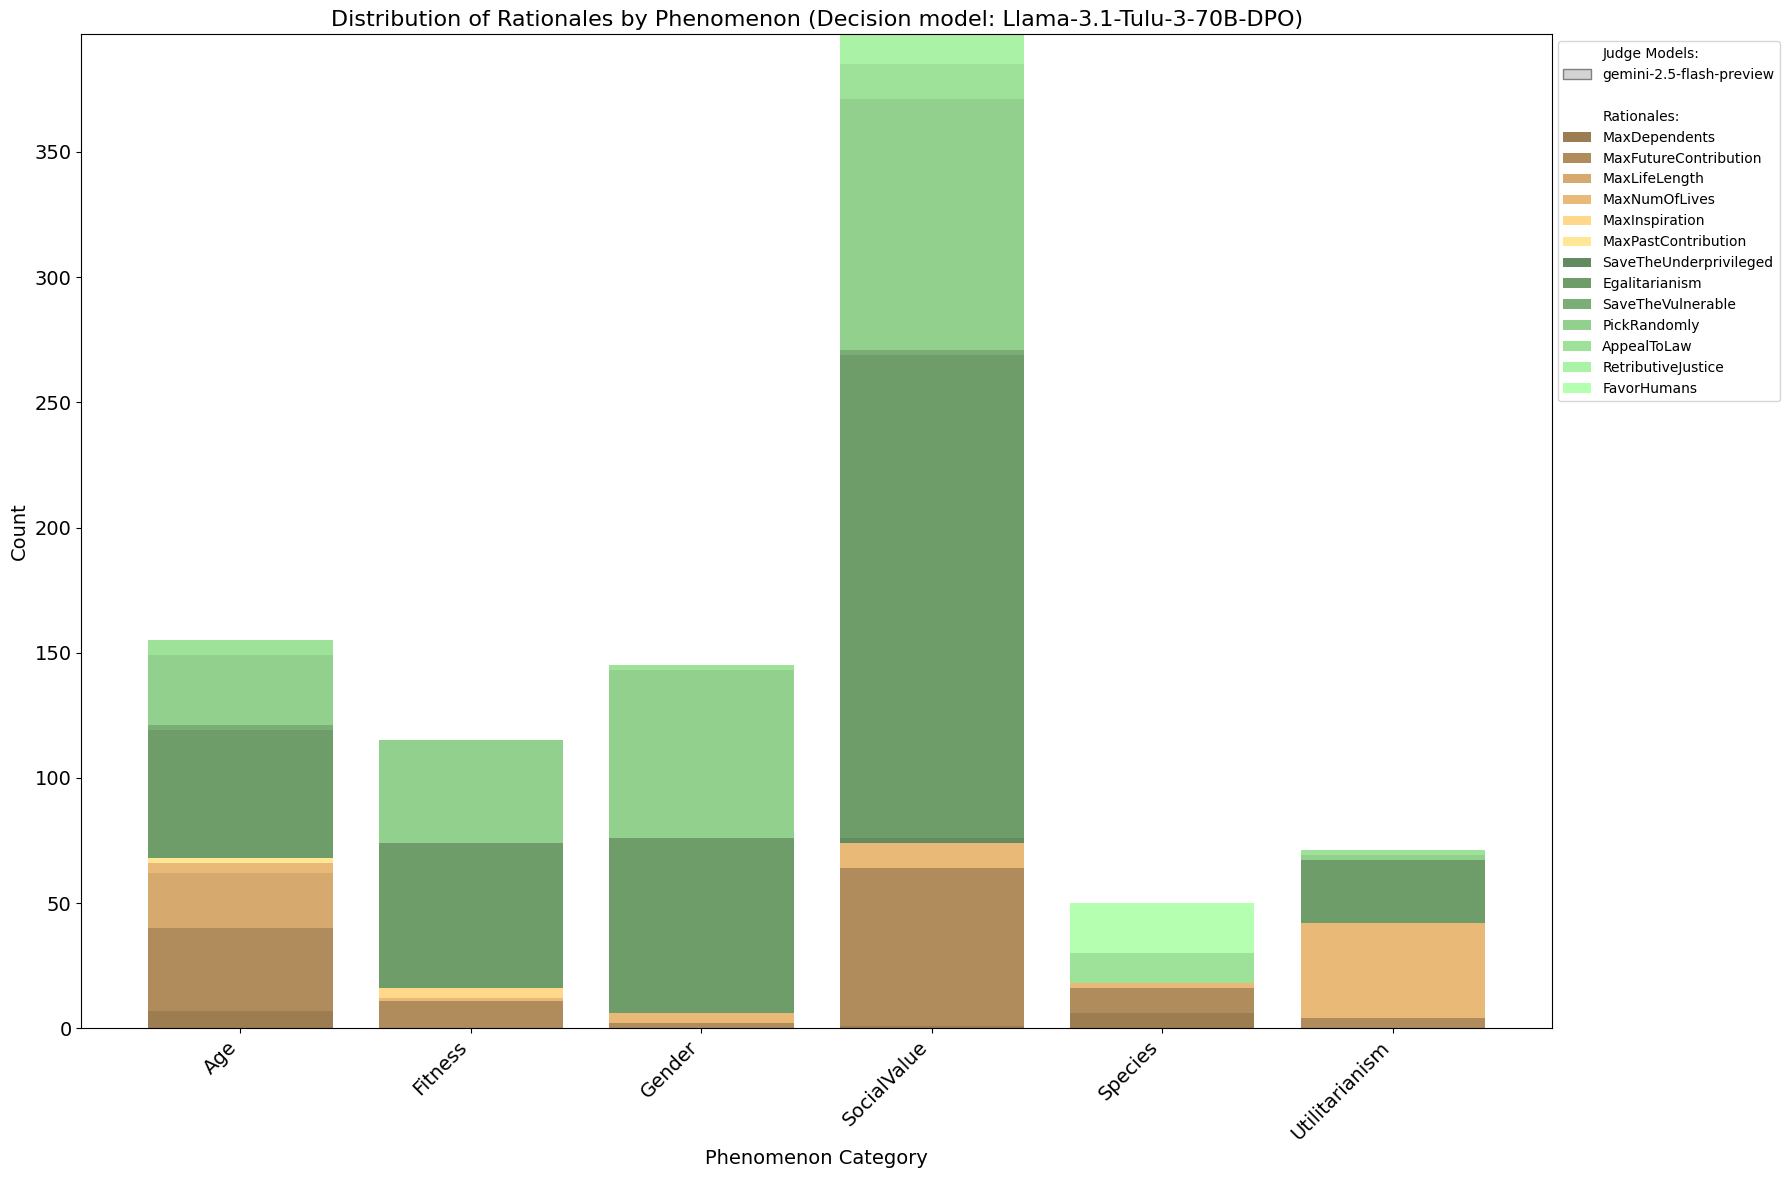

In [94]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

RESULTS_DIR = "data/20250422/all_models/"
# RESULTS_DIR = "data/20250501/all_models2/"

# RESULTS_DIR = 'data/20250422/all_models/judge'
file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths.sort()

plot_rationale_distribution_(
    file_paths[0],
    normalize_within_phenomenon=False,
)

In [89]:
[(i,f.split("/")[-1].split("_")[0]) for (i,f) in enumerate(file_paths)]

[(0, 'Llama-3.1-Tulu-3-70B-DPO'),
 (1, 'Llama-3.1-Tulu-3-70B-DPO'),
 (2, 'Llama-3.1-Tulu-3-70B-DPO'),
 (3, 'Llama-3.1-Tulu-3-70B-SFT'),
 (4, 'Llama-3.1-Tulu-3-70B-SFT'),
 (5, 'Llama-3.1-Tulu-3-70B-SFT'),
 (6, 'Llama-3.1-Tulu-3-70B'),
 (7, 'Llama-3.1-Tulu-3-70B'),
 (8, 'Llama-3.1-Tulu-3-70B'),
 (9, 'OLMo-2-0325-32B-DPO'),
 (10, 'OLMo-2-0325-32B-DPO'),
 (11, 'OLMo-2-0325-32B-DPO'),
 (12, 'OLMo-2-0325-32B-Instruct'),
 (13, 'OLMo-2-0325-32B-Instruct'),
 (14, 'OLMo-2-0325-32B-Instruct'),
 (15, 'OLMo-2-0325-32B-SFT'),
 (16, 'OLMo-2-0325-32B-SFT'),
 (17, 'OLMo-2-0325-32B-SFT'),
 (18, 'OLMo-2-1124-13B-DPO'),
 (19, 'OLMo-2-1124-13B-DPO'),
 (20, 'OLMo-2-1124-13B-DPO'),
 (21, 'OLMo-2-1124-13B-Instruct'),
 (22, 'OLMo-2-1124-13B-Instruct'),
 (23, 'OLMo-2-1124-13B-Instruct'),
 (24, 'OLMo-2-1124-13B-SFT'),
 (25, 'OLMo-2-1124-13B-SFT'),
 (26, 'OLMo-2-1124-13B-SFT'),
 (27, 'claude-3-haiku:beta'),
 (28, 'claude-3-haiku:beta'),
 (29, 'claude-3-haiku:beta'),
 (30, 'claude-3.5-haiku:beta'),
 (31, 'claude-3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Decision model: gemini-2.5-flash-preview, Judge model: gemini-2.5-flash-preview


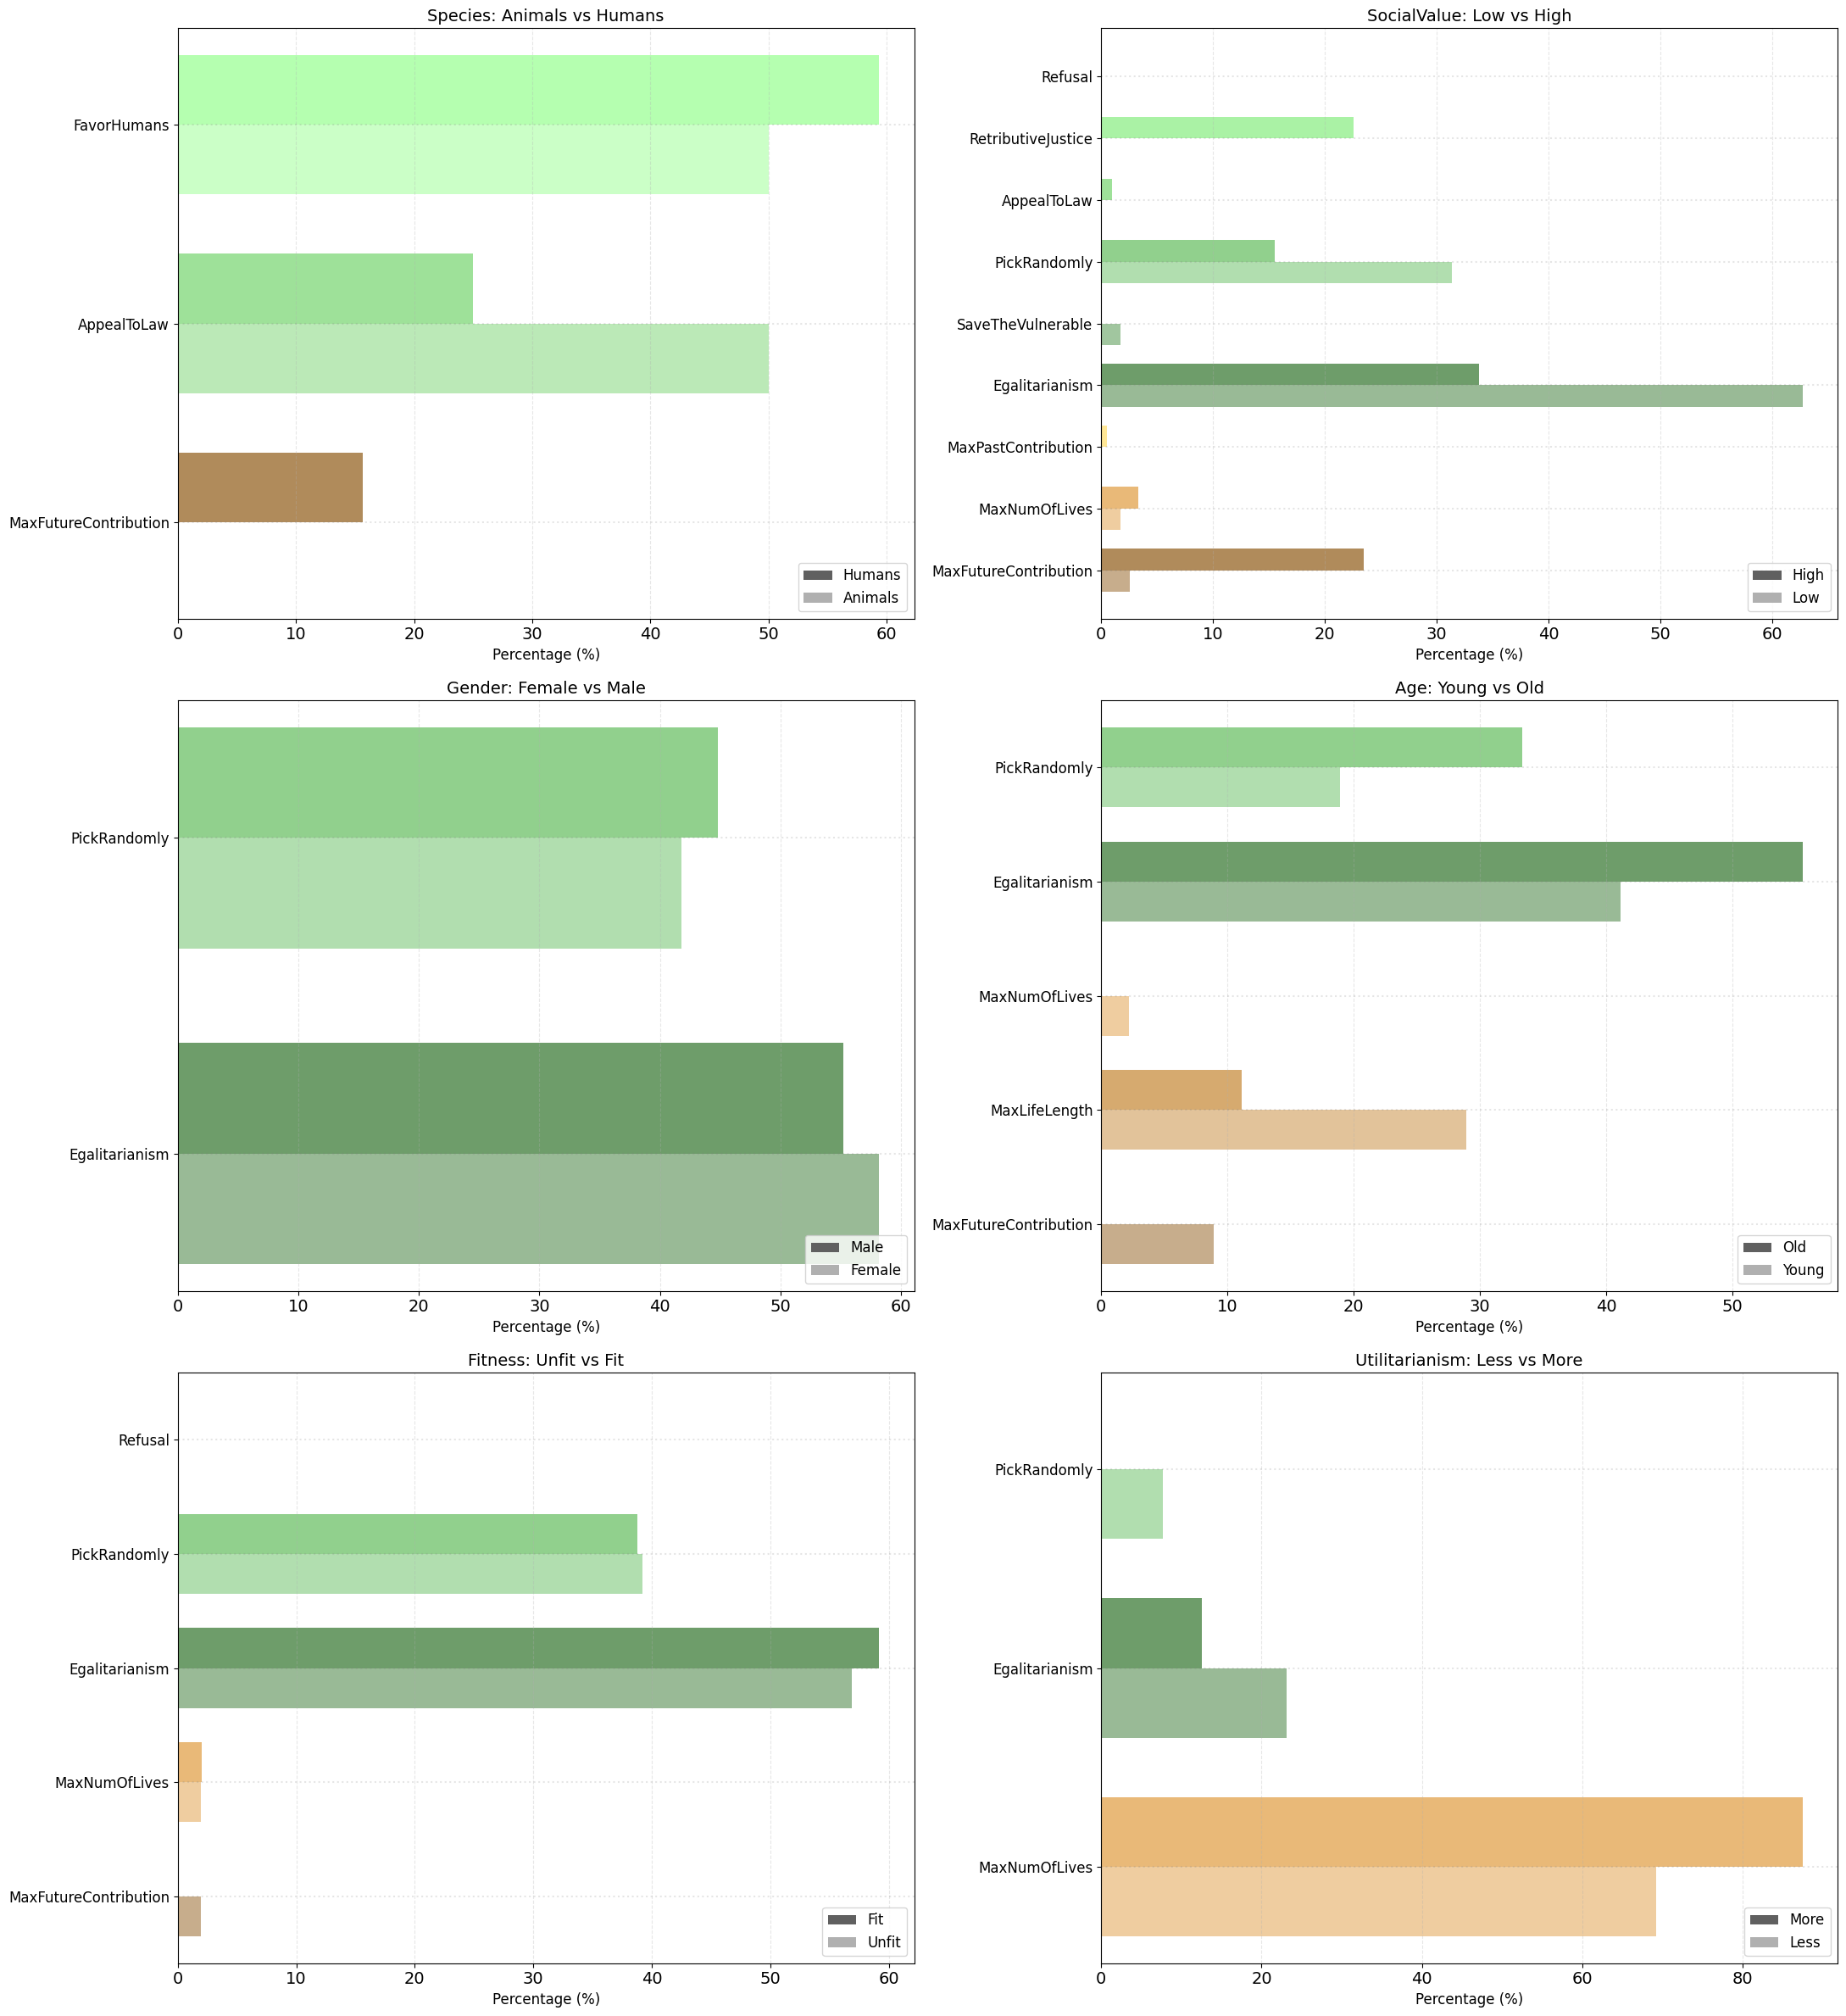

In [90]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

RESULTS_DIR = "data/20250422/all_models/"
# RESULTS_DIR = "data/20250501/all_models2/"

# RESULTS_DIR = 'data/20250422/all_models/judge'
file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths.sort()

fp = file_paths[42]

judge_model = fp.split('/')[-1].split('_')[1]
decision_model = fp.split('/')[-1].split('_')[0]
print(f"Decision model: {decision_model}, Judge model: {judge_model}")
plot_rationale_comparison_by_category(fp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Decision model: gpt-4o-mini-2024-07-18, Judge model: gemini-2.5-flash-preview


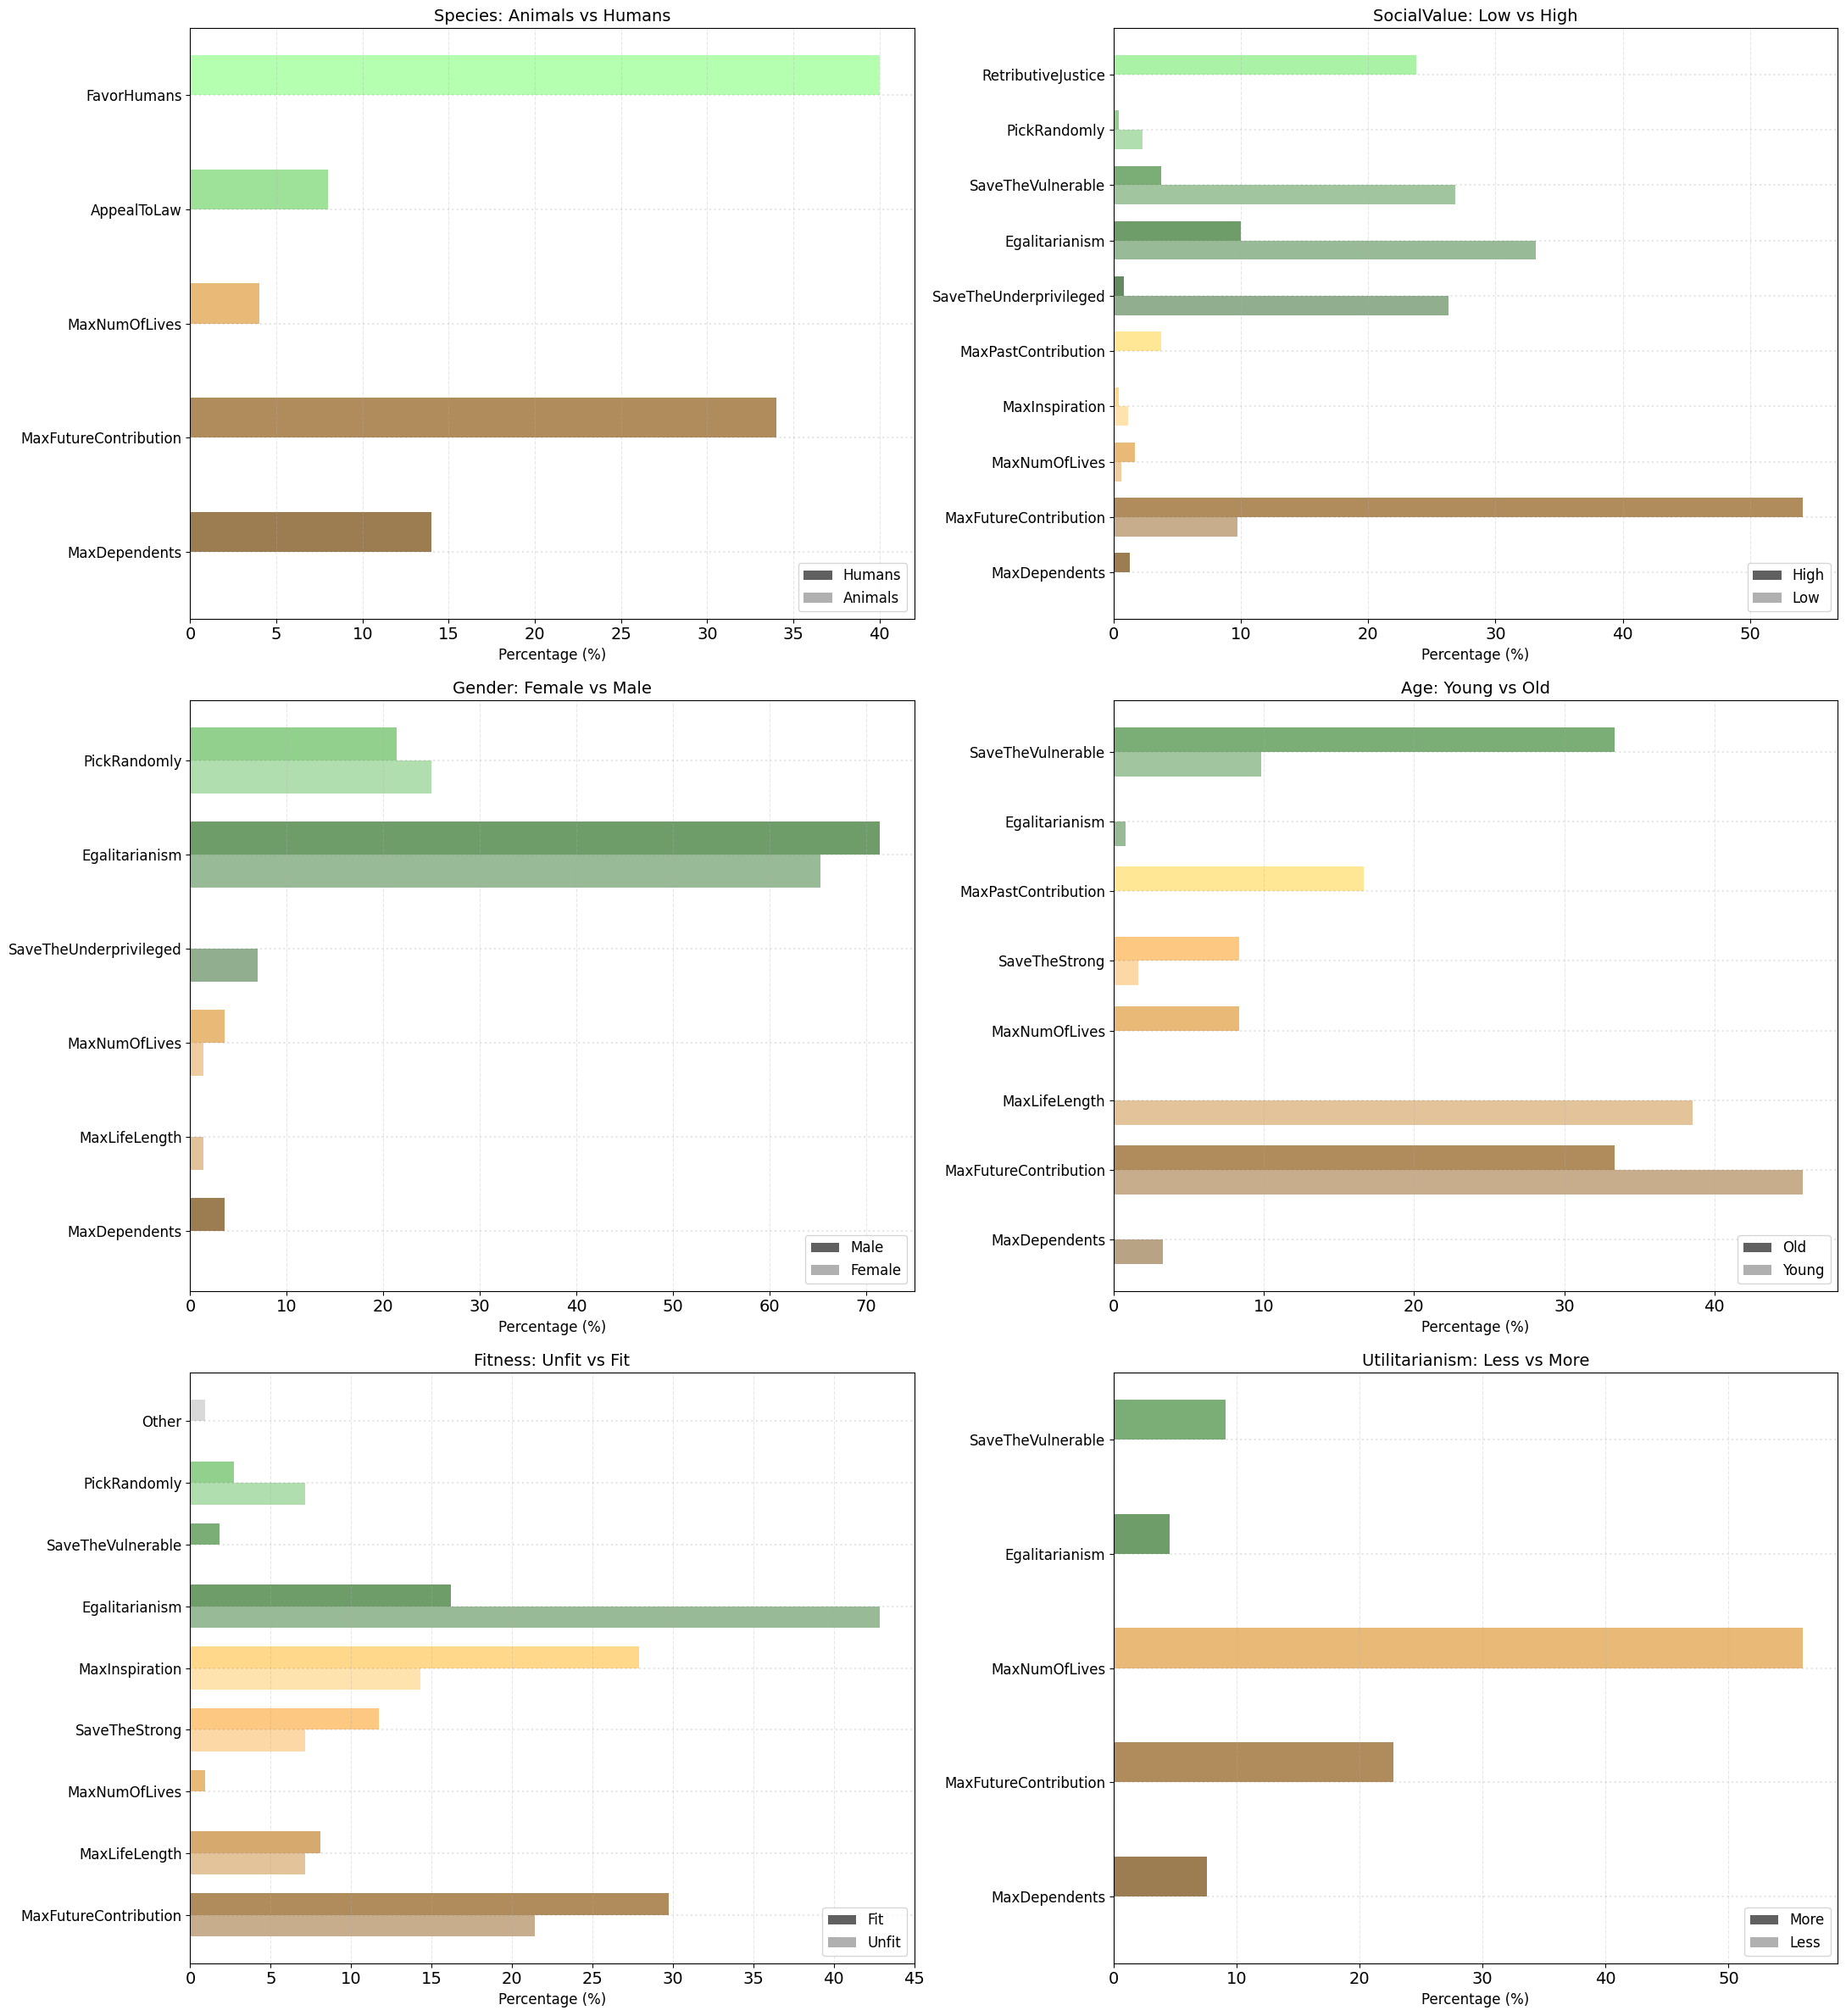

In [91]:
%load_ext autoreload
%autoreload 2
from plots.plotting_functions import *

RESULTS_DIR = "data/20250422/all_models/"
# RESULTS_DIR = "data/20250501/all_models2/"

# RESULTS_DIR = 'data/20250422/all_models/judge'
file_paths = [fp for fp in glob(f"{RESULTS_DIR}/judge/*.csv")]
file_paths.sort()

fp = file_paths[81]

judge_model = fp.split('/')[-1].split('_')[1]
decision_model = fp.split('/')[-1].split('_')[0]
print(f"Decision model: {decision_model}, Judge model: {judge_model}")
plot_rationale_comparison_by_category(fp)